# Exercise for Chapter 3 (Solutions)

In [615]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import scipy.stats as stats
from pandas.plotting import register_matplotlib_converters
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

register_matplotlib_converters()


plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

import warnings
warnings.filterwarnings('ignore')


In [21]:
pd.options.display.max_columns = None
pd.options.display.width=None
sns.set(style="darkgrid")

### Exercise 1

- The files d_15stocks.csv and m_15stocks.csv contain daily and monthly stock returns data for 15 stocks from January 11, 2000 to March 31, 2013.
- The files d_indexes.csv and m_indexes.csv contain daily and monthly returns data for the volume-weighted and equal-weighted S&P 500market indices (VWRETD and EWRETD, respectively) from January 11, 2000 to March 31,2013.

Using daily and monthly returns data for 15 individual stocks from d_15stocks.csv and m_15stocks.csv, and the equal-weighted and value-weighted CRSP market indexes (EWRETD and VWRETD, respectively) from d_indexes.csv and m_indexes.csv, performthe following statistical analyses. For the subsample analyses, split the available observations into equal-sized subsamples or at regime changes visually noticeable from the time series plots.
1. Compute the sample mean $\hat{\mu}$, standard deviation $\hat{\sigma}$, and first-order autocorrelation coefficient $\hat{\rho(1)}$ for daily simple returns over the entire sample period for the 15 stocks and two indexes. Split the sample into 4 equal subperiods and compute the same statistics in each subperiod—are they stable over time?
2. Plot histograms of daily simple returns for VWRETD and EWRETD over the entire sample period. Plot another histogramof the normal distribution with mean and variance equal to the sample mean and variance of the returns plotted in the first histograms. Do daily simple returns look approximately normal? Which looks closer to normal: VWRETD or EWRETD?
3. Using daily simple returns for the sample period, construct 99% confidence intervals for $\hat{\mu}$ for VWRETD and EWRETD, and the 15 individual stock return series. Divide the sample into 4 equal subperiods and construct 99%confidence intervals in each of the four subperiods for the 17 series—do they shift a great deal?
4. Compute the skewness, kurtosis, and studentized range of daily simple returns of VWRETD, EWRETD, and the 15 individual stocks over the entire sample period, and in each of the 4 equal subperiods. Which of the skewness, kurtosis, and studentized range estimates are statistically different from the skewness, kurtosis, and studentized range of a normal random variable at the 5% level? For these 17 series, perform the same calculations using monthly data. What do you conclude about the normality of these return series, and why?

#### Part 1

Let's load the data look at a few rows and then plot to see what the data looks like.

In [253]:
d_15stock = pd.read_csv('../datasets/d_15stocks.csv',index_col=['TICKER','date'],parse_dates=['date'])
m_15stock = pd.read_csv('../datasets/m_15stocks.csv',index_col='date',parse_dates=['date'])
d_indexes = pd.read_csv('../datasets/d_indexes.csv',index_col='caldt',parse_dates=['caldt'])
d_indexes.index.name='date'
d_indexes.columns = d_indexes.columns.str.upper()

m_indexes = pd.read_csv('../datasets/m_indexes.csv',index_col='caldt',parse_dates=['caldt'])
m_indexes.index.name='date'
m_indexes.columns = m_indexes.columns.str.upper()

In [515]:
daily_df = d_15stock.RET.unstack(level=0).join(d_indexes)
daily_df.head()
stock_cols = d_15stock.index.levels[0]
idx_cols = ['VWRETD','EWRETD']

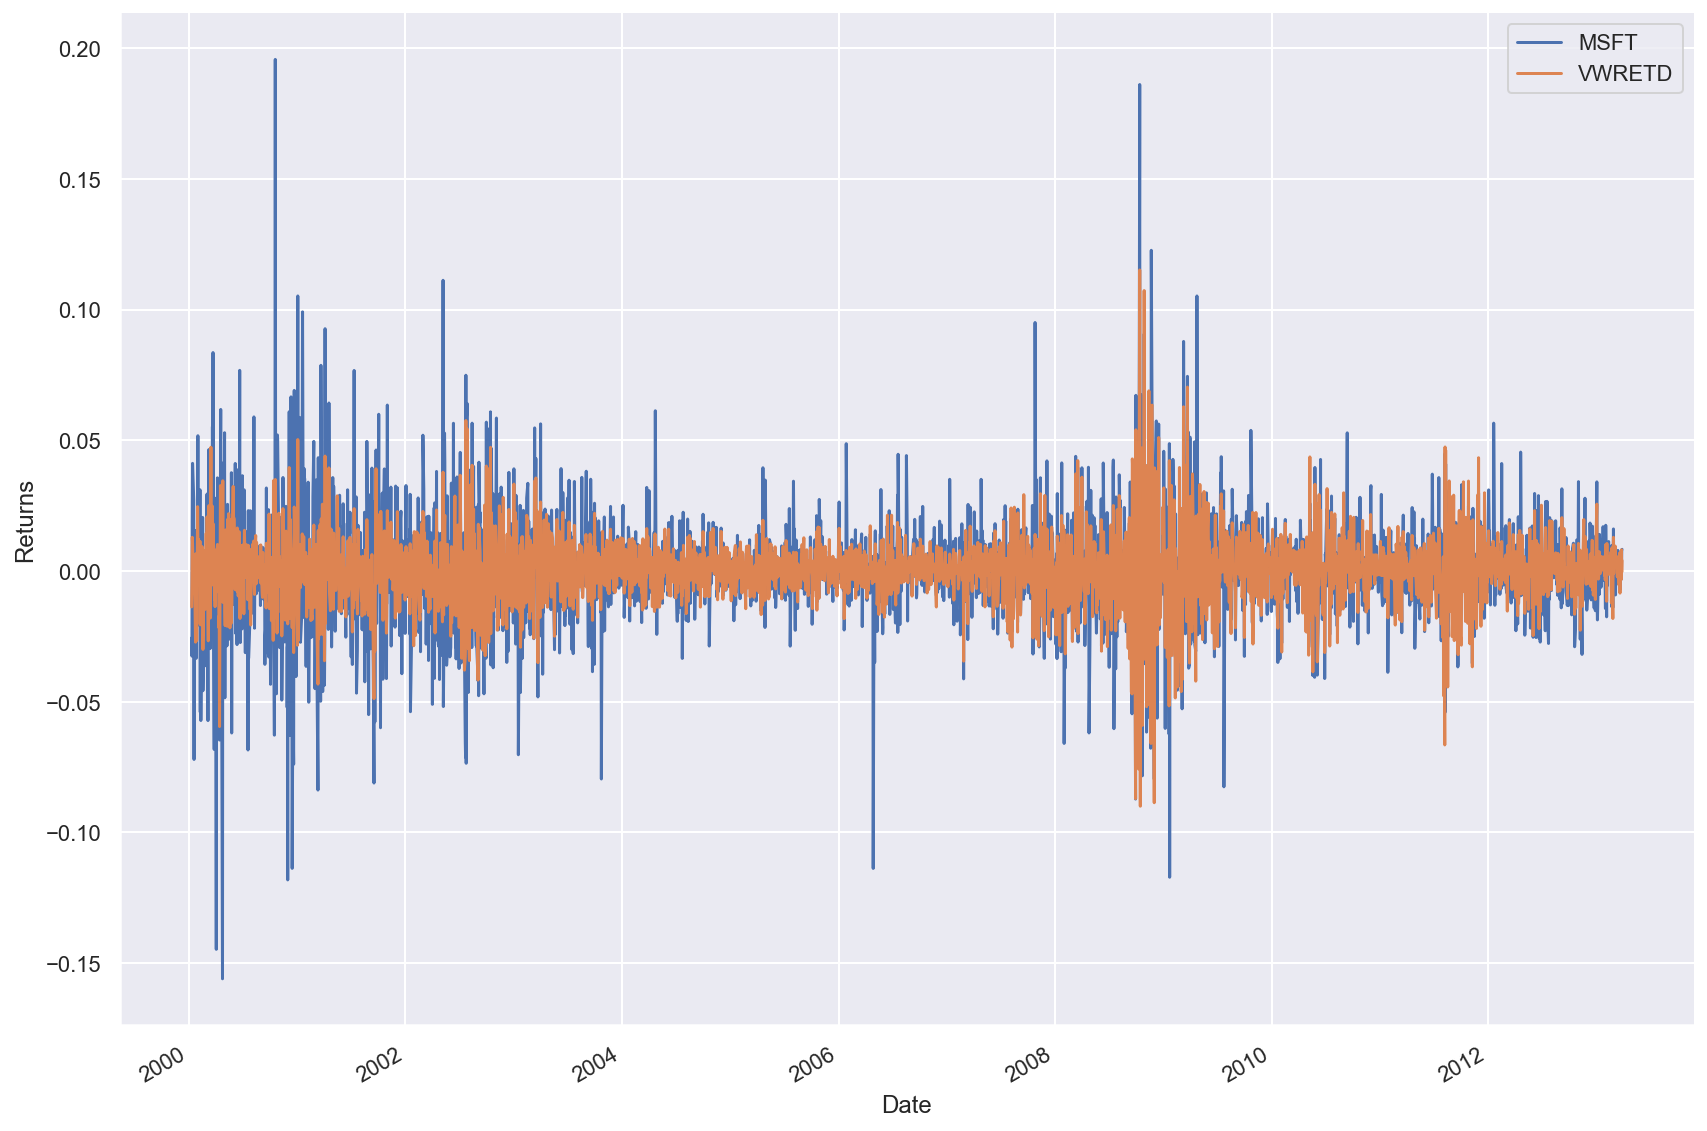

In [255]:
fig,ax = plt.subplots(figsize=(12,8))
_ = daily_df.MSFT.plot(ax = ax)
_ = daily_df.VWRETD.plot(ax = ax)
_ = plt.xlabel('Date')
_ = plt.ylabel('Returns')
_ = plt.legend()
sns.despine()
plt.tight_layout()
plt.show()

In [256]:
stats = pd.concat({'mean':daily_df.mean(axis=0),'std':daily_df.std(axis=0),'autocorr':daily_df.apply(lambda s: s.autocorr(lag=1))},axis=1)
stats

,mean,std,autocorr
AIG,-0.000037,0.043796,0.134600
AXP,0.000494,0.025470,-0.068588
BA,0.000493,0.020422,-0.011943
DD,0.000218,0.019074,-0.035077
DIS,0.000406,0.020970,-0.040681
HD,0.000347,0.021970,0.016098
HPQ,0.000189,0.025477,-0.015097
IBM,0.000382,0.017711,-0.049531
JPM,0.000515,0.028367,-0.084815
MCD,0.000493,0.016110,-0.021483


Let's split the time period in 4 subperiods and create separate stats for each

In [534]:
date_split = np.array_split(daily_df.index.values,4)
for i, d_split in enumerate(date_split):
    daily_df.loc[d_split,'SubGroup'] = i+1
daily_df.loc[:,'SubGroup'] = daily_df.SubGroup.astype(int)
daily_df = daily_df.set_index('SubGroup',append=True)

In [559]:
[(np.datetime_as_string(d.min(),'D'),np.datetime_as_string(d.max(),'D')) for d in date_split]

[('2000-01-11', '2003-05-05'),
 ('2003-05-06', '2006-08-21'),
 ('2006-08-22', '2009-12-08'),
 ('2009-12-09', '2013-03-28')]

In [535]:
def sub_group_stats(df):
    return pd.concat({'mean':df.mean(axis=0),'std':df.std(axis=0),'autocorr':df.apply(lambda s: s.autocorr(lag=1))},axis=1)
sub_group_stats = daily_df.groupby('SubGroup').apply(sub_group_stats)

Let's plot the stats for the stocks and the indeces separately for the varius Subgroups. It is clear the statistics for stocks vary quite a bit over time. The outlier is AIG in the period that includes 2008 (majorl impacted by the subprime crises and had to be bailed out). The indices are more stable, the power of averaging!

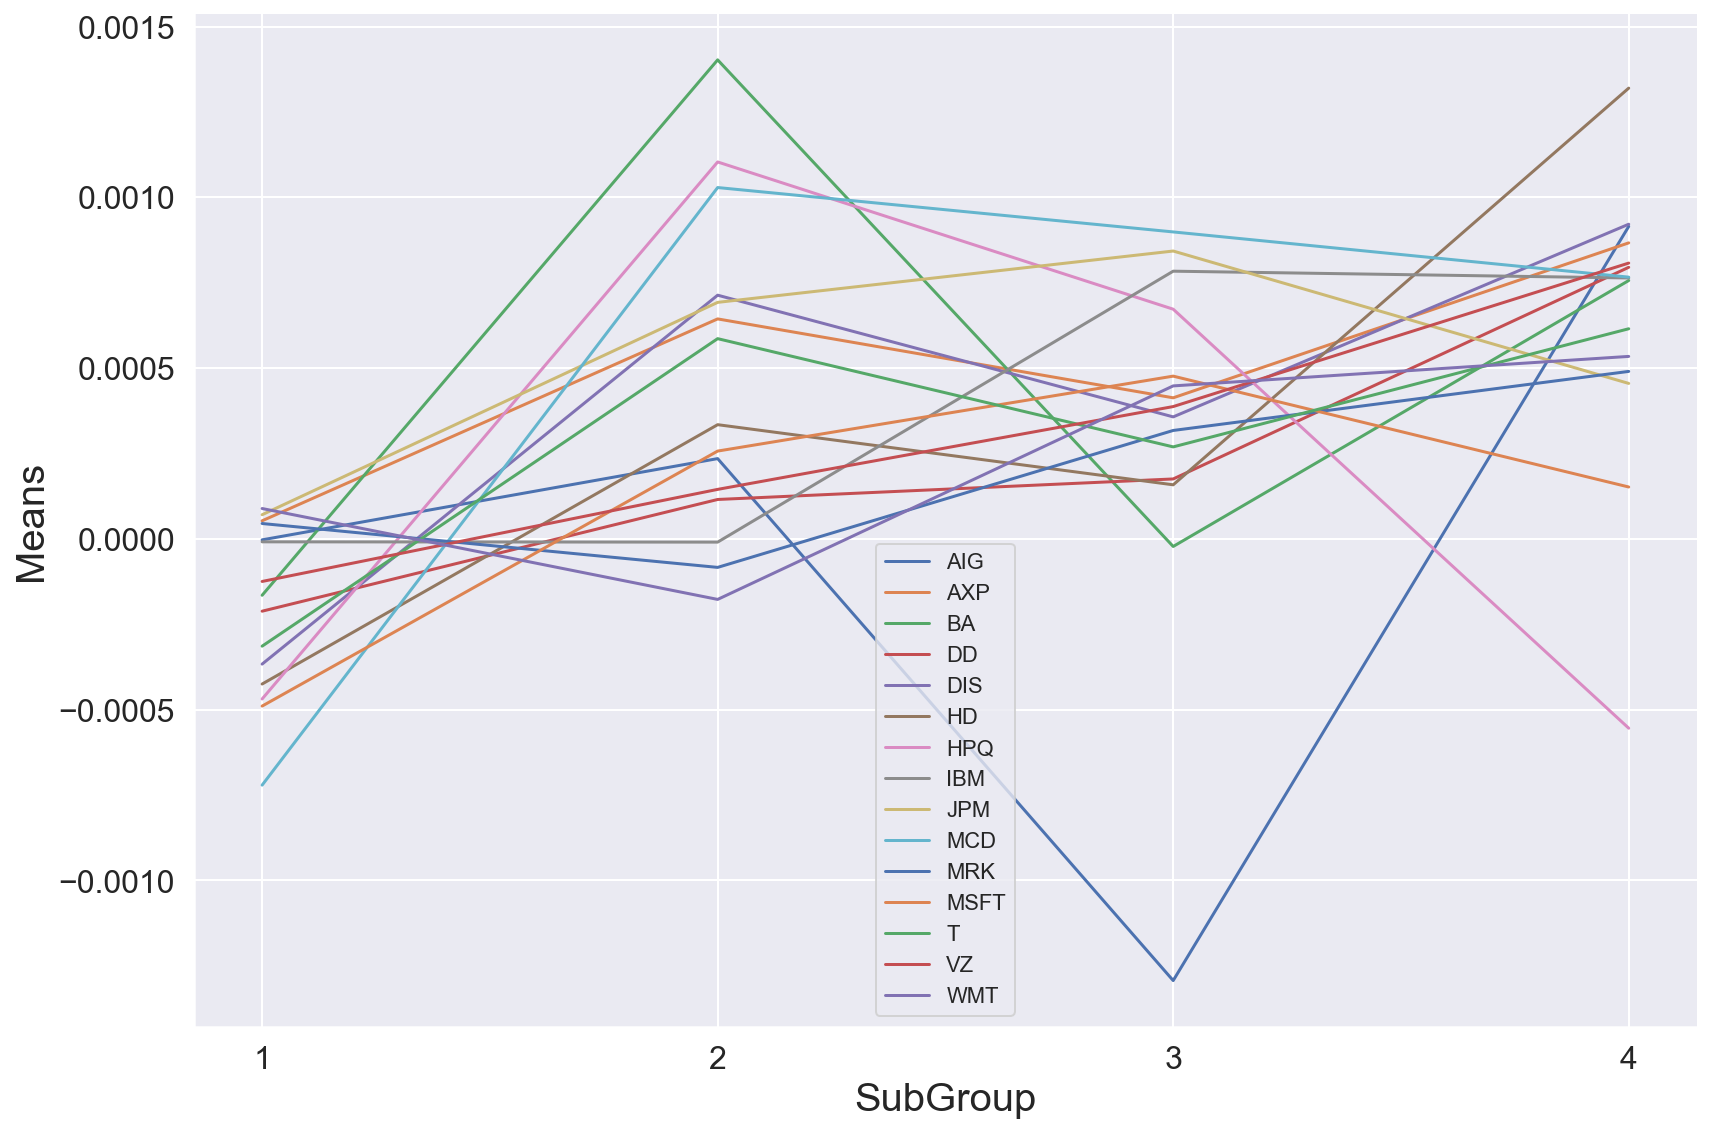

In [516]:
fig,ax = plt.subplots(figsize=(12,8))
sub_group_stats.loc[pd.IndexSlice[:,stock_cols],'mean'].unstack(level=1).plot(ax = ax)
_ = plt.xlabel('SubGroup')
_ = plt.ylabel('Means')
_ = plt.legend()
_ = plt.xticks(ticks = range(1,5),labels = [str(i) for i in range(1,5) ])
sns.despine()
plt.tight_layout()
plt.show()

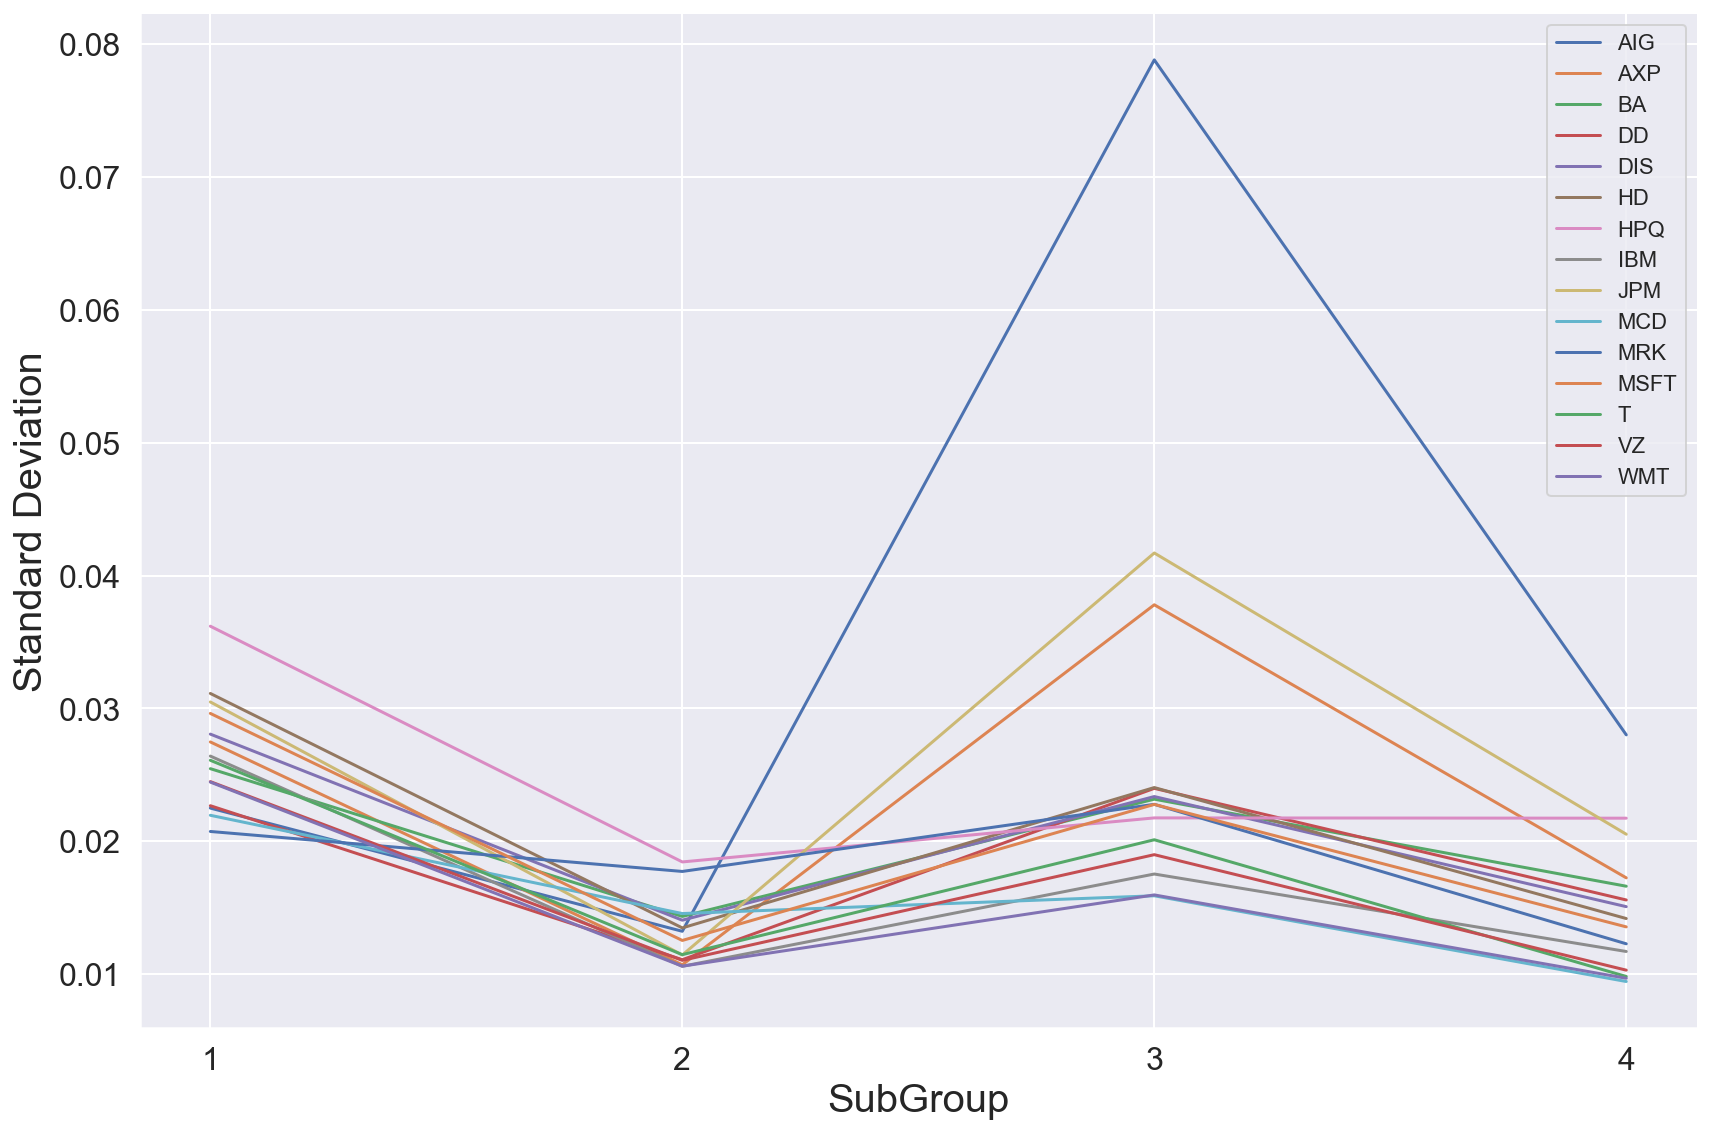

In [517]:
fig,ax = plt.subplots(figsize=(12,8))
sub_group_stats.loc[pd.IndexSlice[:,stock_cols],'std'].unstack(level=1).plot(ax = ax)
_ = plt.xlabel('SubGroup')
_ = plt.ylabel('Standard Deviation')
_ = plt.legend()
_ = plt.xticks(ticks = range(1,5),labels = [str(i) for i in range(1,5) ])
sns.despine()
plt.tight_layout()
plt.show()

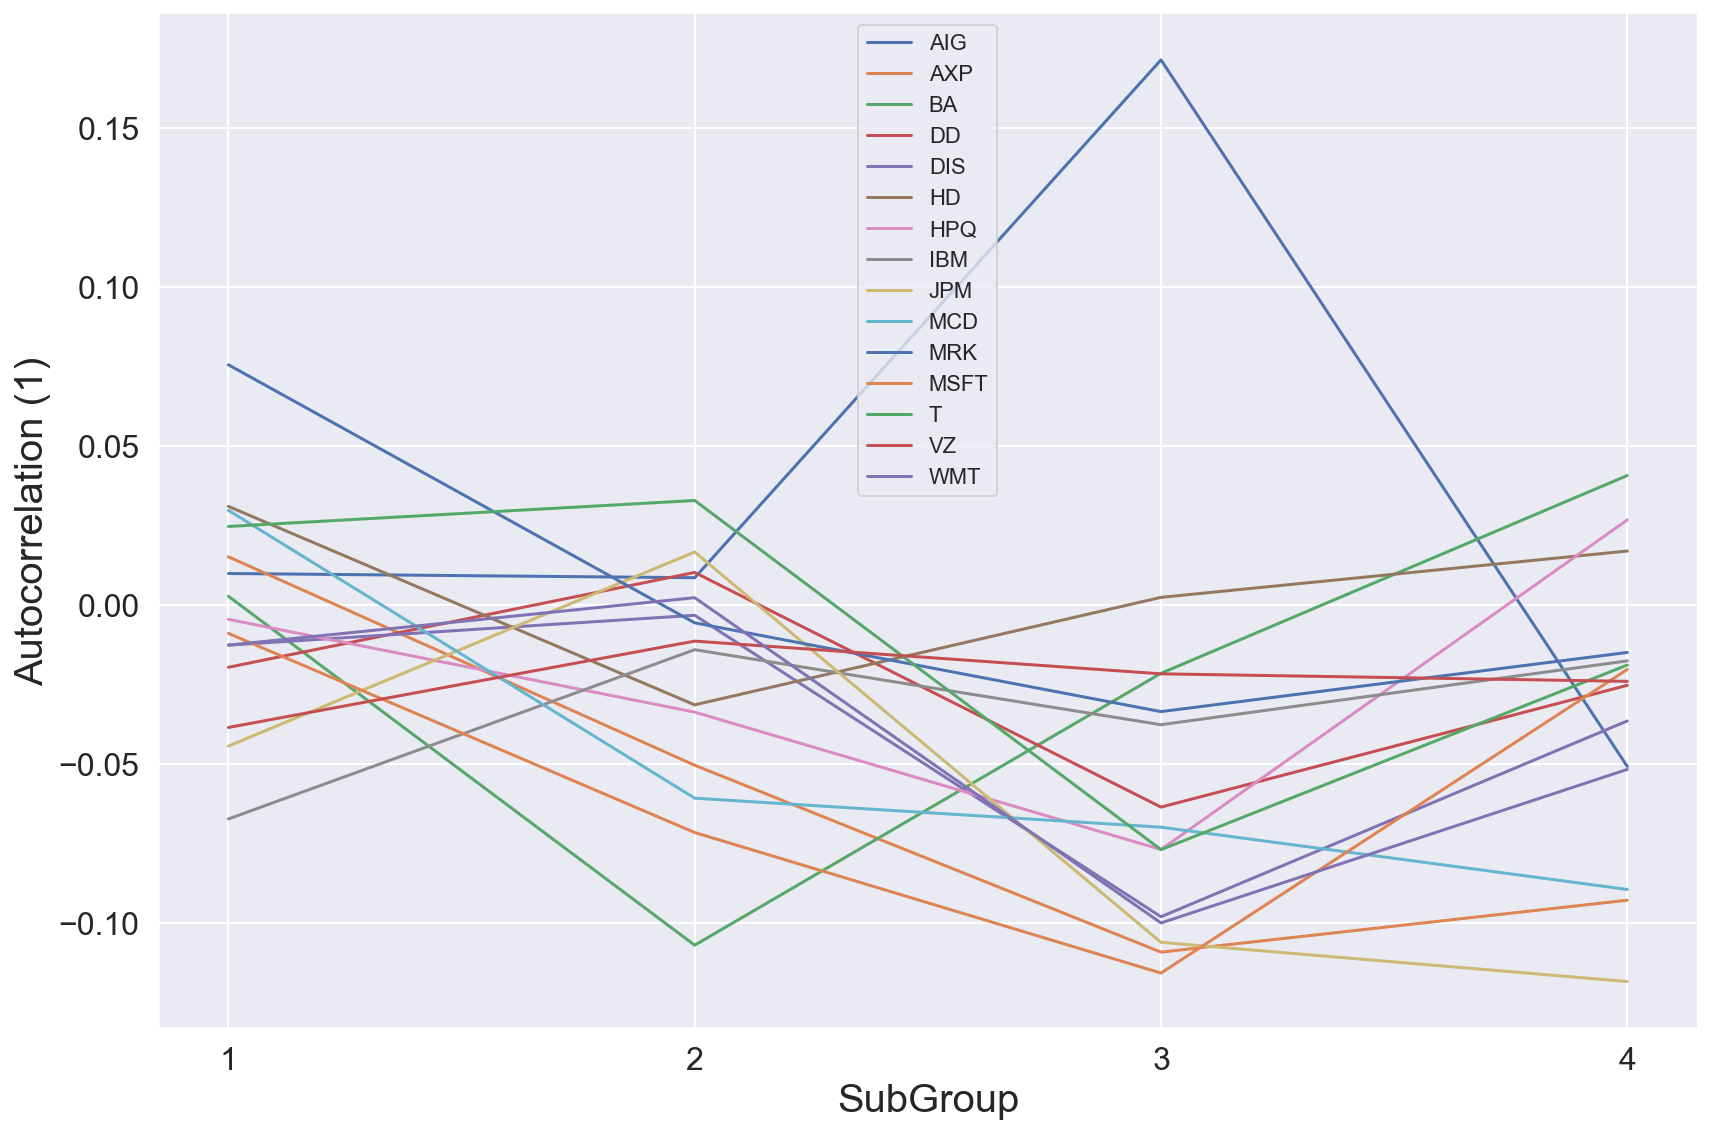

In [518]:
fig,ax = plt.subplots(figsize=(12,8))
sub_group_stats.loc[pd.IndexSlice[:,stock_cols],'autocorr'].unstack(level=1).plot(ax = ax)
_ = plt.xlabel('SubGroup')
_ = plt.ylabel('Autocorrelation (1)')
_ = plt.legend()
_ = plt.xticks(ticks = range(1,5),labels = [str(i) for i in range(1,5) ])
sns.despine()
plt.tight_layout()
plt.show()

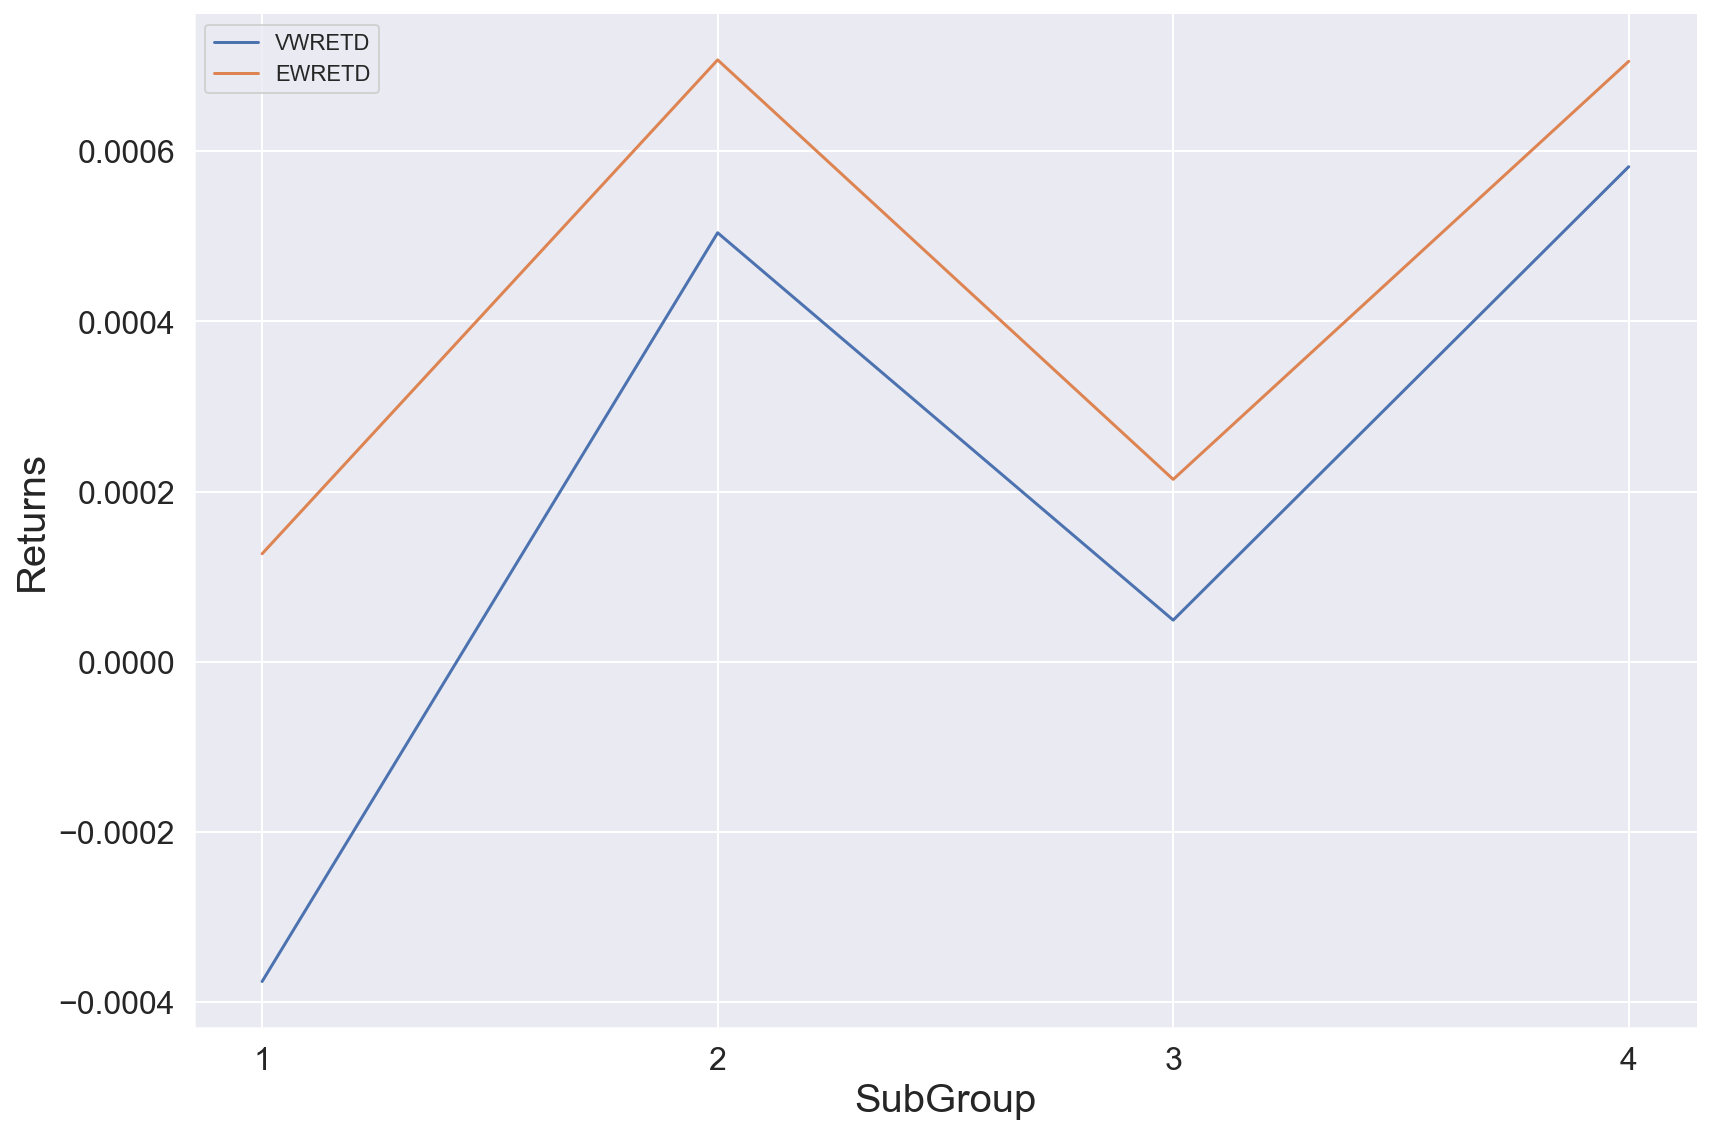

In [519]:
fig,ax = plt.subplots(figsize=(12,8))
sub_group_stats.loc[pd.IndexSlice[:,idx_cols],'mean'].unstack(level=1).plot(ax = ax)
_ = plt.xlabel('SubGroup')
_ = plt.ylabel('Returns')
_ = plt.legend()
_ = plt.xticks(ticks = range(1,5),labels = [str(i) for i in range(1,5) ])
sns.despine()
plt.tight_layout()
plt.show()

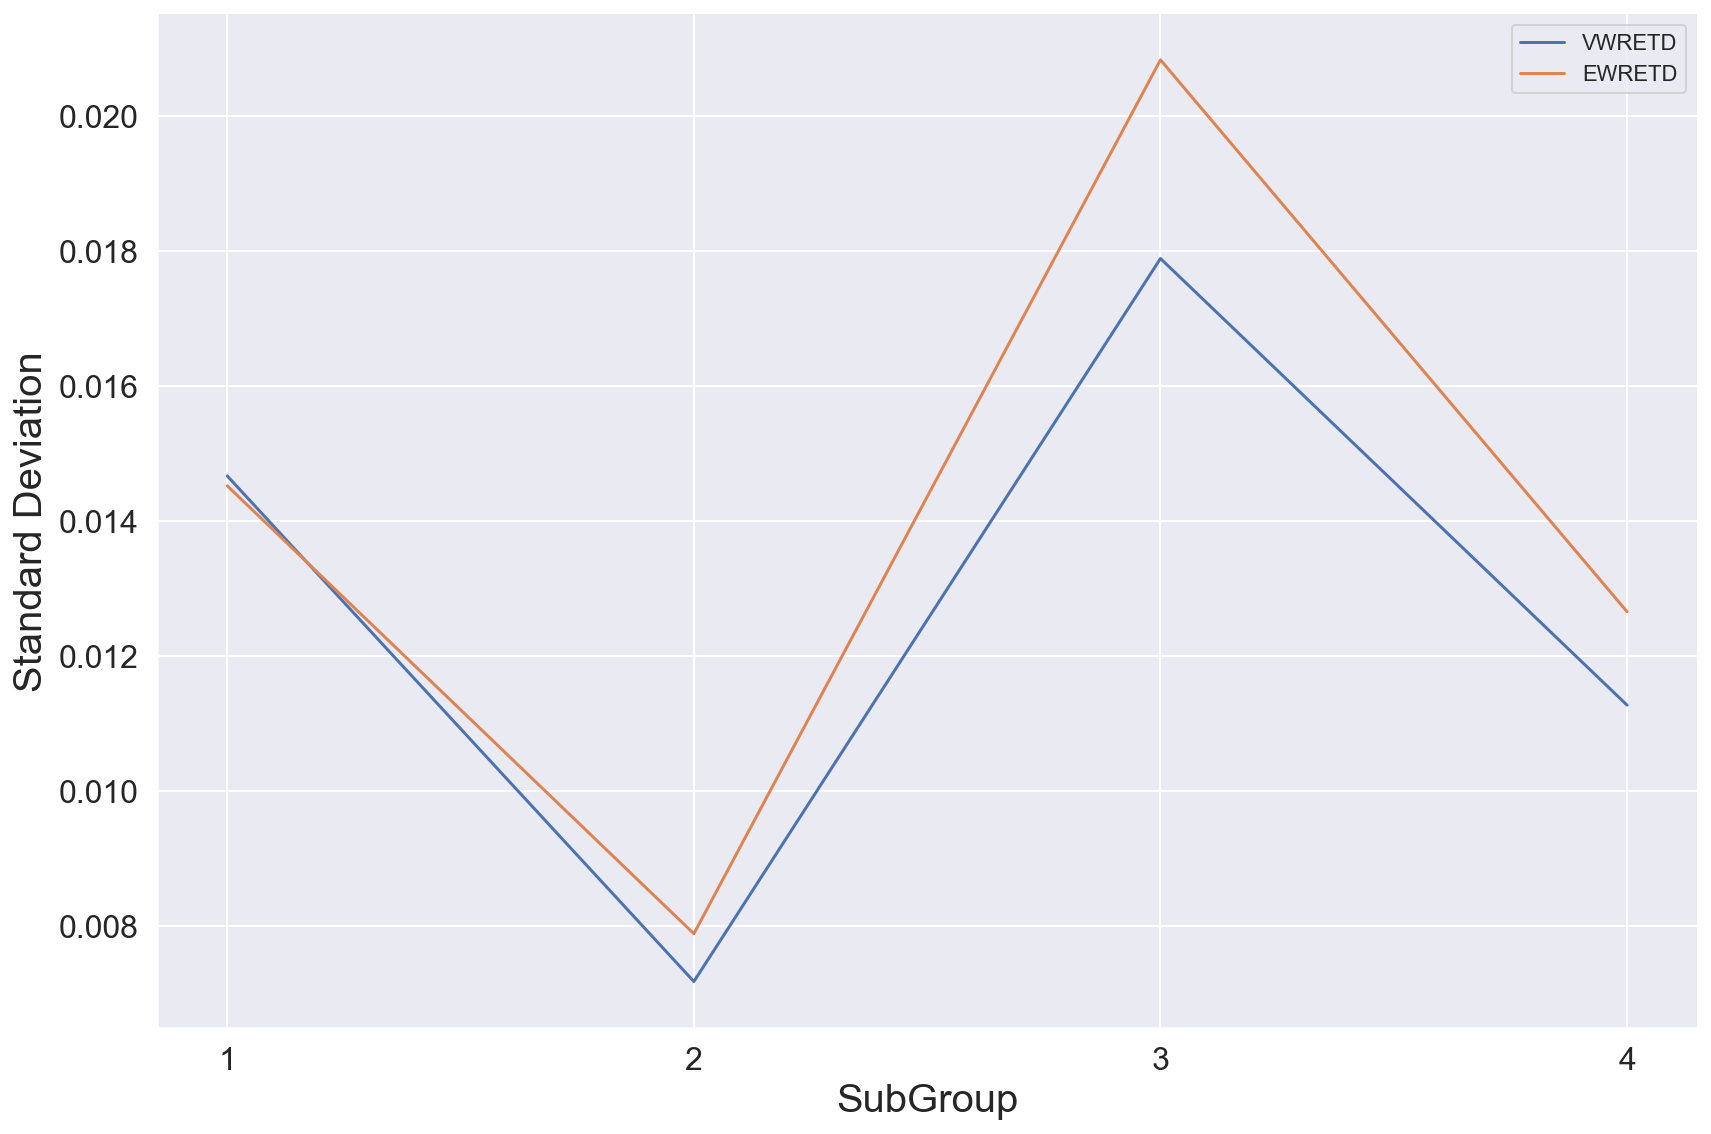

In [520]:
fig,ax = plt.subplots(figsize=(12,8))
sub_group_stats.loc[pd.IndexSlice[:,idx_cols],'std'].unstack(level=1).plot(ax = ax)
_ = plt.xlabel('SubGroup')
_ = plt.ylabel('Standard Deviation')
_ = plt.legend()
_ = plt.xticks(ticks = range(1,5),labels = [str(i) for i in range(1,5) ])
sns.despine()
plt.tight_layout()
plt.show()

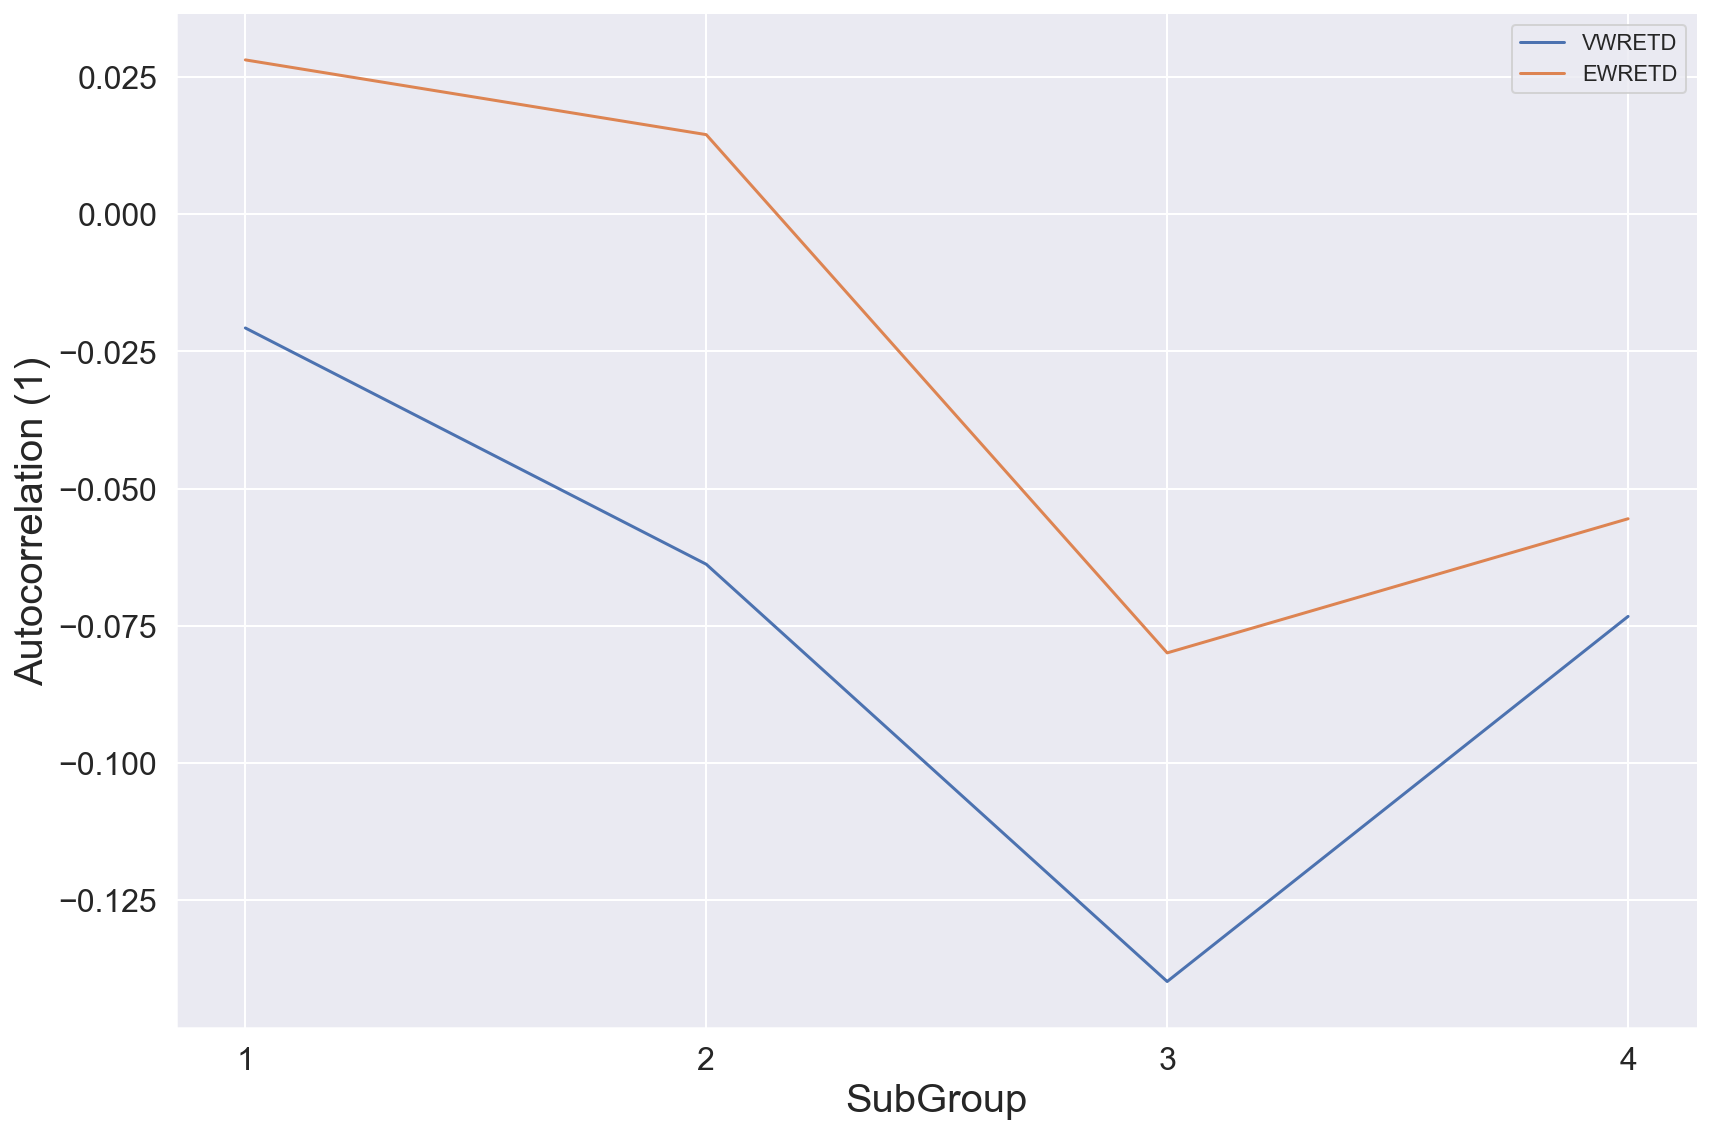

In [521]:
fig,ax = plt.subplots(figsize=(12,8))
sub_group_stats.loc[pd.IndexSlice[:,idx_cols],'autocorr'].unstack(level=1).plot(ax = ax)
_ = plt.xlabel('SubGroup')
_ = plt.ylabel('Autocorrelation (1)')
_ = plt.legend()
_ = plt.xticks(ticks = range(1,5),labels = [str(i) for i in range(1,5) ])
sns.despine()
plt.tight_layout()
plt.show()

#### Part 2

In [265]:
means = d_indexes.mean(axis=0)
stds = d_indexes.std(axis=0)
n_points = d_indexes.shape[0]
idx_1 = pd.Series(np.random.normal(means[0],stds[0],n_points),name='Normal')
idx_2 = pd.Series(np.random.normal(means[1],stds[1],n_points),name='Normal')

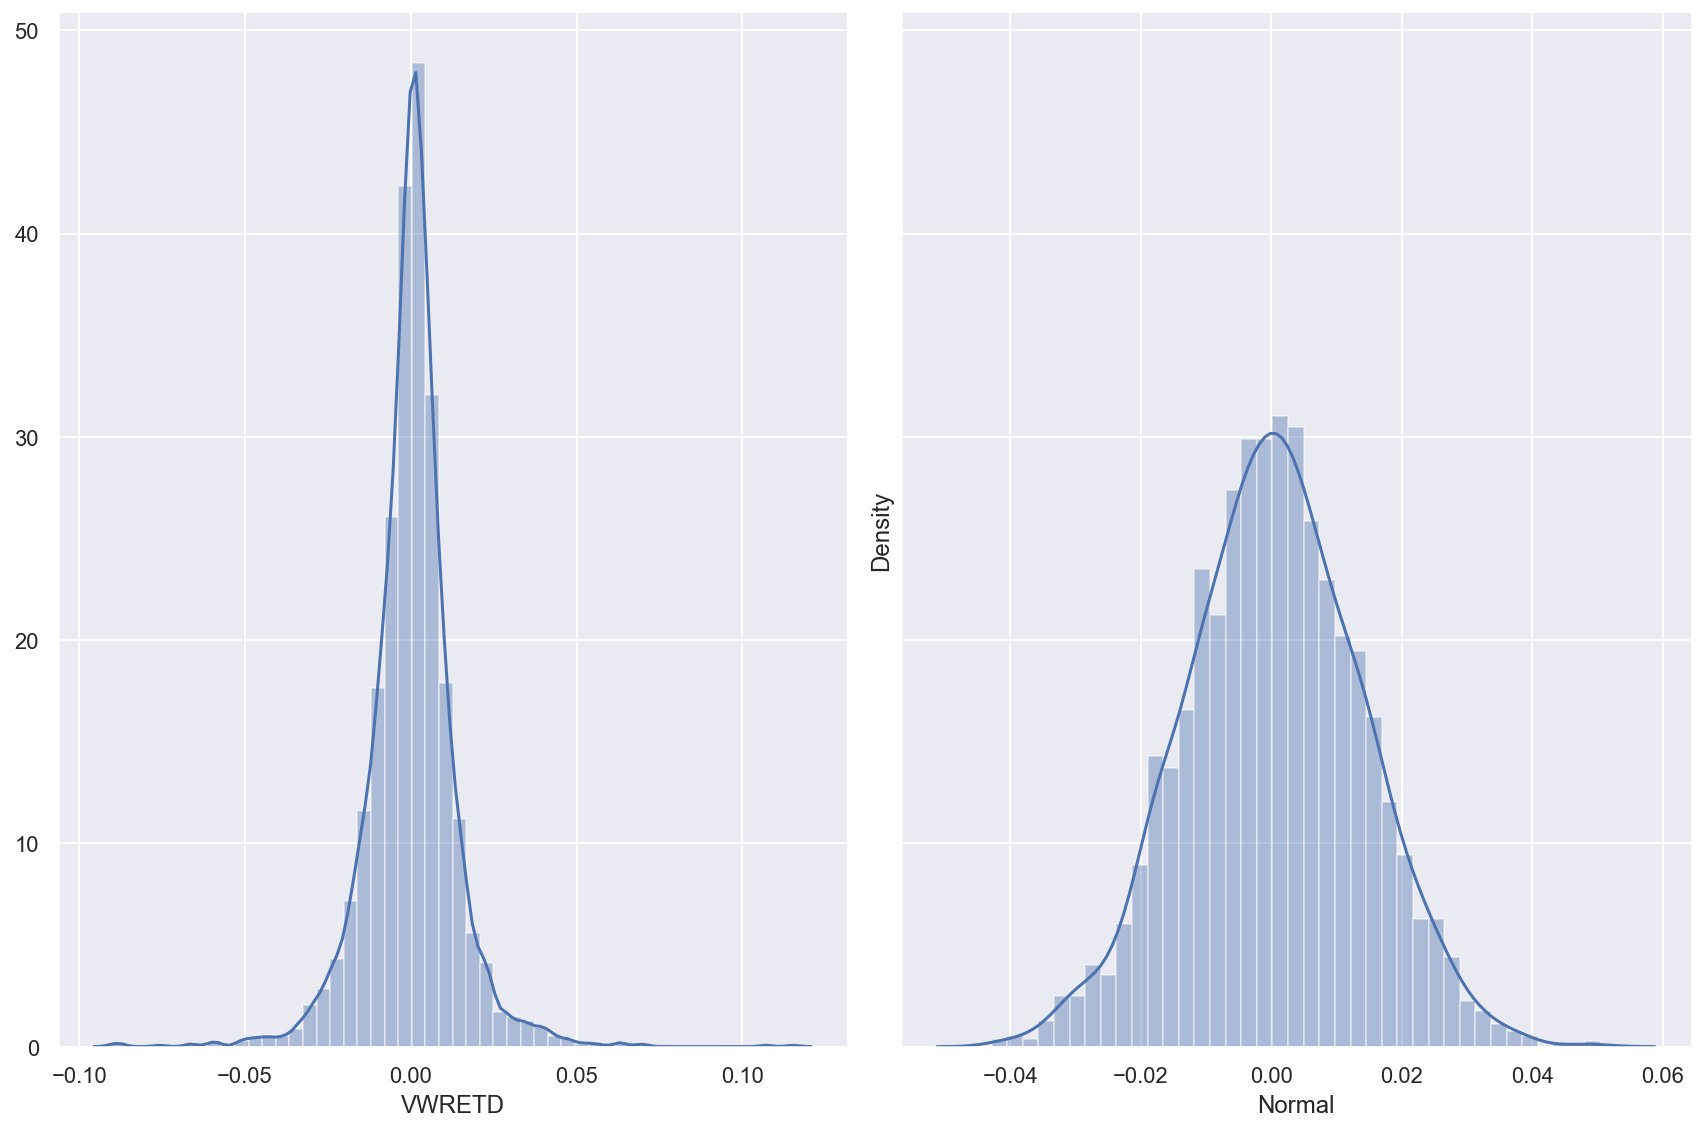

In [266]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,8),sharey=True)
_ = sns.distplot(d_indexes.VWRETD,ax=ax1)
_ = sns.distplot(idx_1,ax=ax2)
_ = plt.ylabel('Density')
sns.despine()
plt.tight_layout()
plt.show()

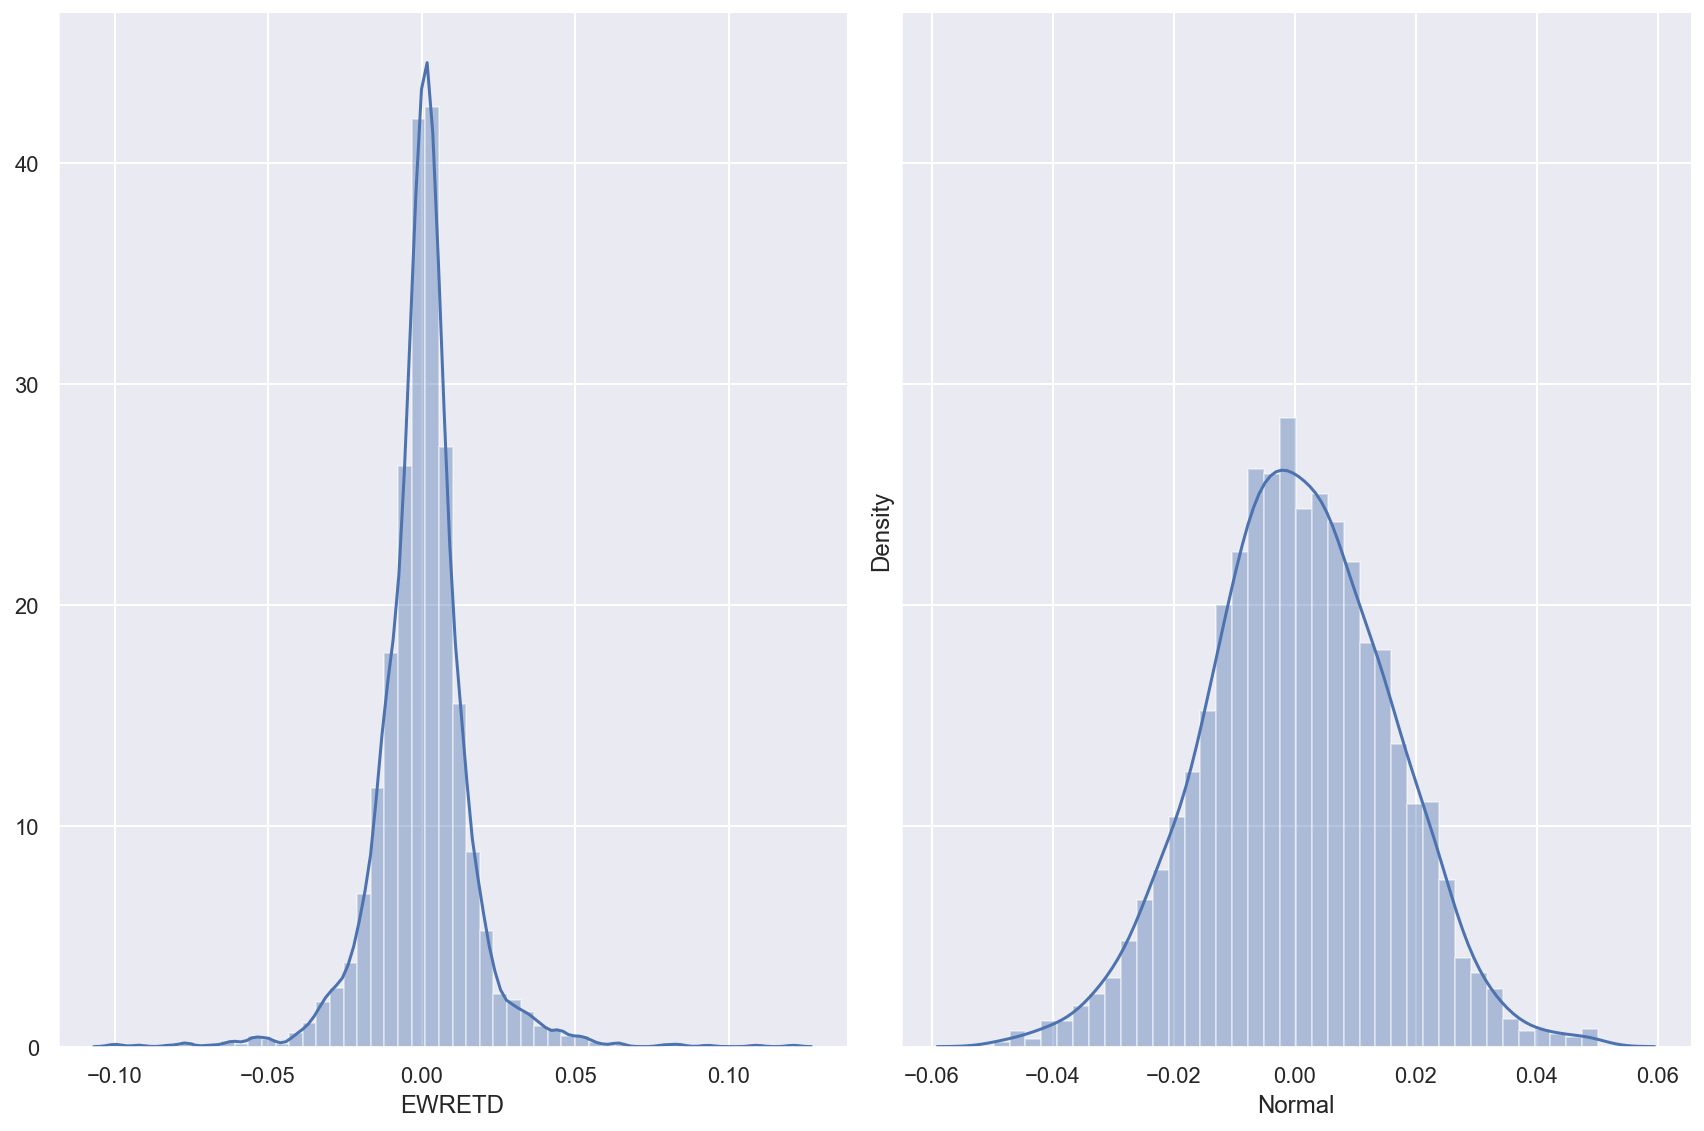

In [267]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,8),sharey=True)
_ = sns.distplot(d_indexes.EWRETD,ax=ax1)
_ = sns.distplot(idx_2,ax=ax2)
_ = plt.ylabel('Density')
sns.despine()
plt.tight_layout()
plt.show()

Neither distribution of returns looks Normal but the equally weighted index looks definitively more normal than the value (cap weighted) index

#### Part 3

To Caluclate confidence intervals of the mean a good package is the statsmodel package using the DescrStatsW funtion to get descriptive statistis. One of the outputs it **tconfint_mean** function.
Let's create a function we can apply for every colum to create the structure we need

In [480]:
def calc_confidence_interval(x):
    ci = sms.DescrStatsW(x).tconfint_mean(alpha=0.01)
    mean = x.mean()
    return pd.Series({'lower_bound':ci[0], 'mean':mean, 'upper_bound':ci[1]})

In [481]:
conf_interval = daily_df.apply(calc_confidence_interval).T

In [482]:
conf_interval

,lower_bound,mean,upper_bound
AIG,-0.001995,-0.000037,0.001921
AXP,-0.000645,0.000494,0.001633
BA,-0.000420,0.000493,0.001406
DD,-0.000634,0.000218,0.001071
DIS,-0.000531,0.000406,0.001344
HD,-0.000636,0.000347,0.001329
HPQ,-0.000951,0.000189,0.001328
IBM,-0.000409,0.000382,0.001174
JPM,-0.000753,0.000515,0.001784
MCD,-0.000227,0.000493,0.001213


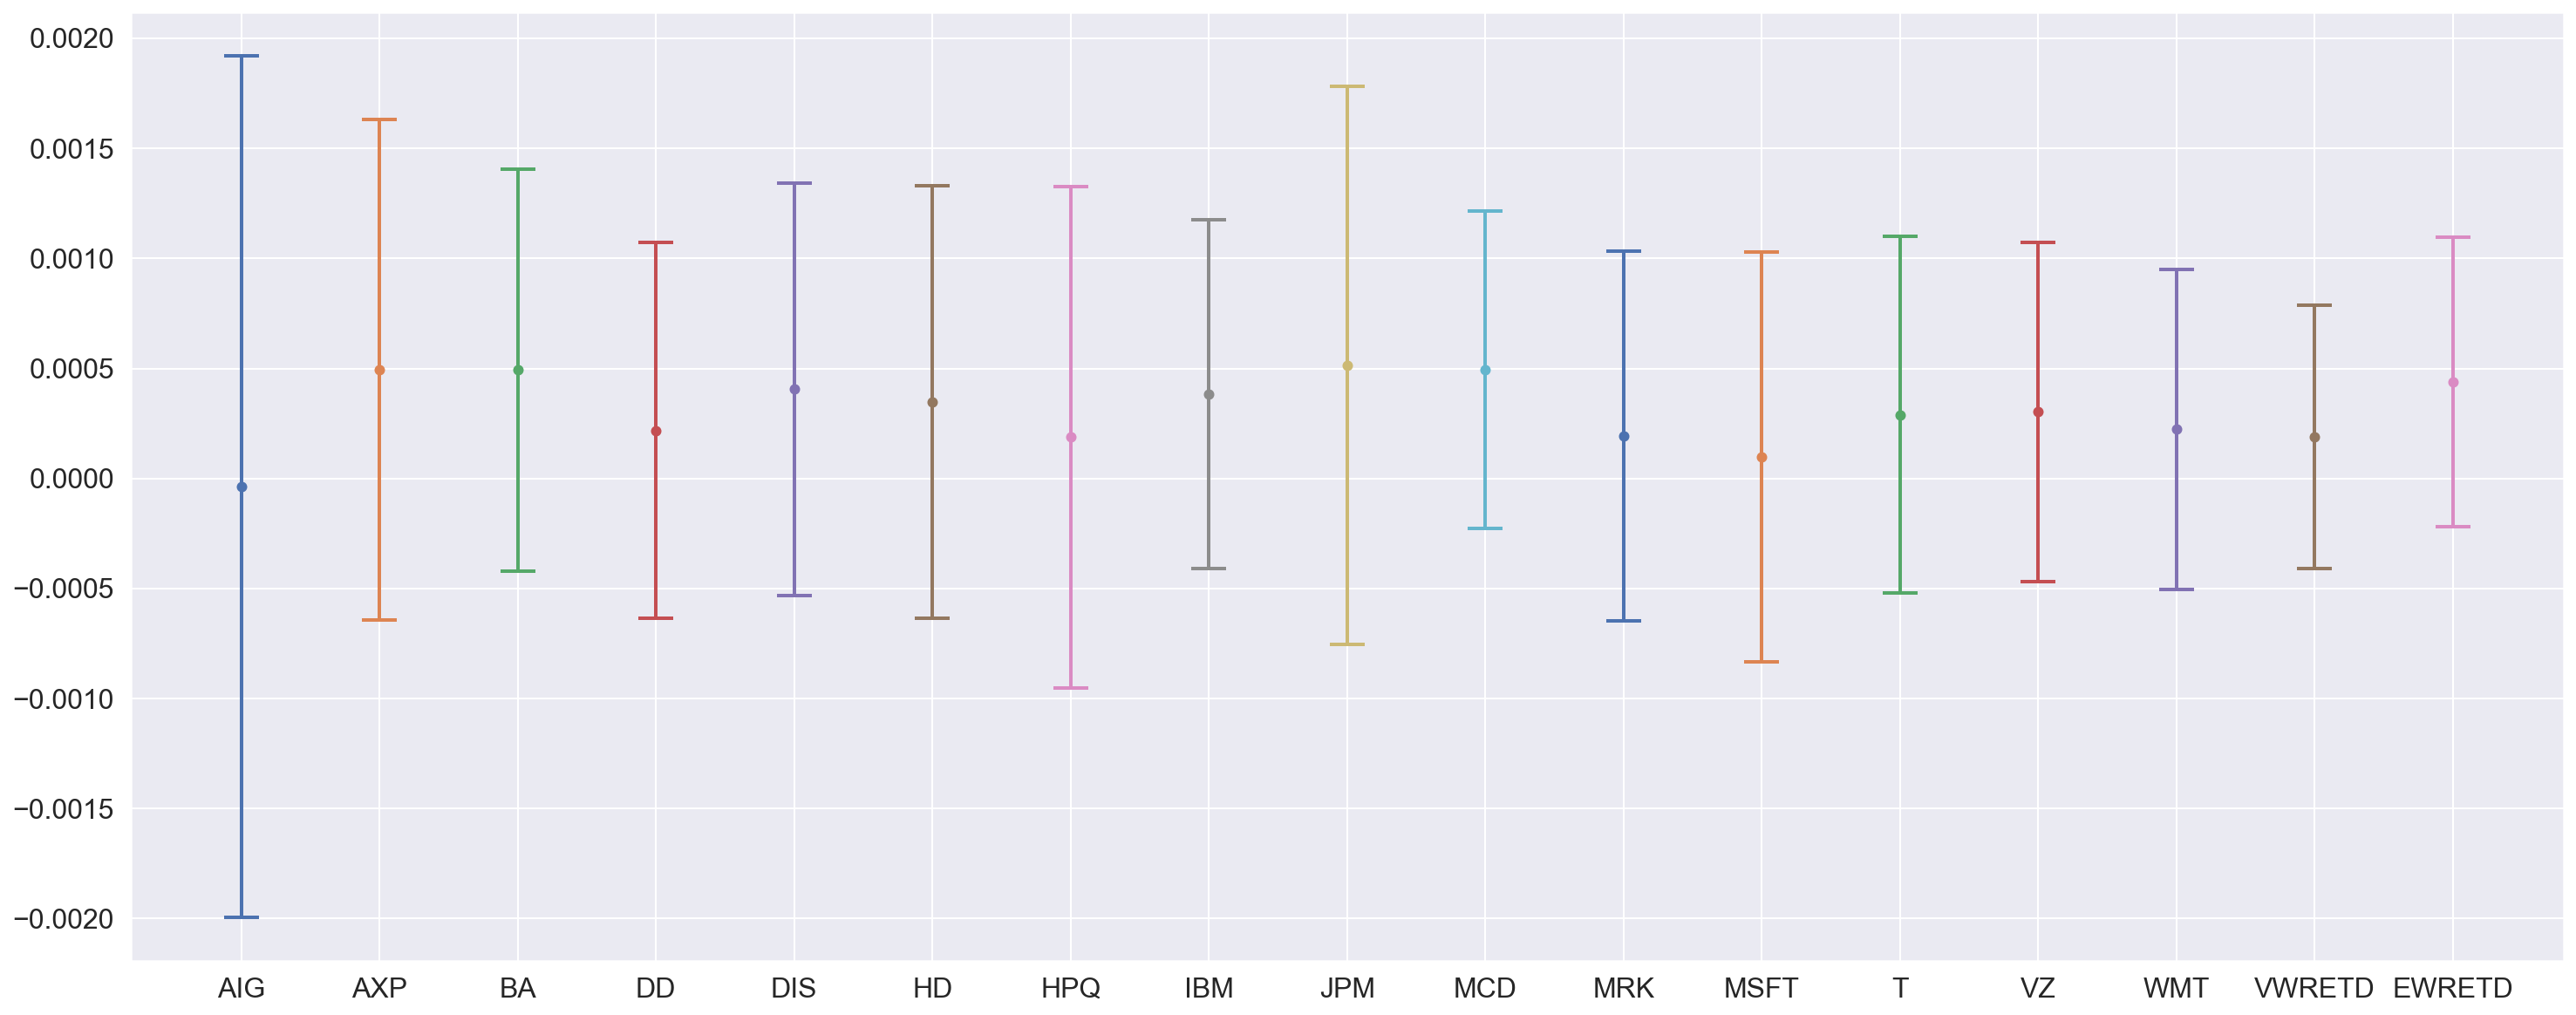

In [483]:
fig,ax = plt.subplots(figsize=(25,10))
for i in range(17):
    colors = sns.color_palette(n_colors= 17)
    entry = conf_interval.iloc[i]
    plt.plot( (i,i),(entry.lower_bound,entry.upper_bound),marker='_',color=cm.colors.to_rgba(colors[i]),linewidth=2.0,markersize=20.0,markeredgewidth=2.0)
    plt.plot(i,entry['mean'],marker='.',c=cm.colors.to_rgba(colors[i]),markersize=10.0)
plt.xticks(ticks=range(17),labels=conf_interval.index)
plt.show()    

In [484]:
conf_interval_subgroup = daily_df.stack().groupby(level=[1,2]).apply(calc_confidence_interval).unstack(level=2)

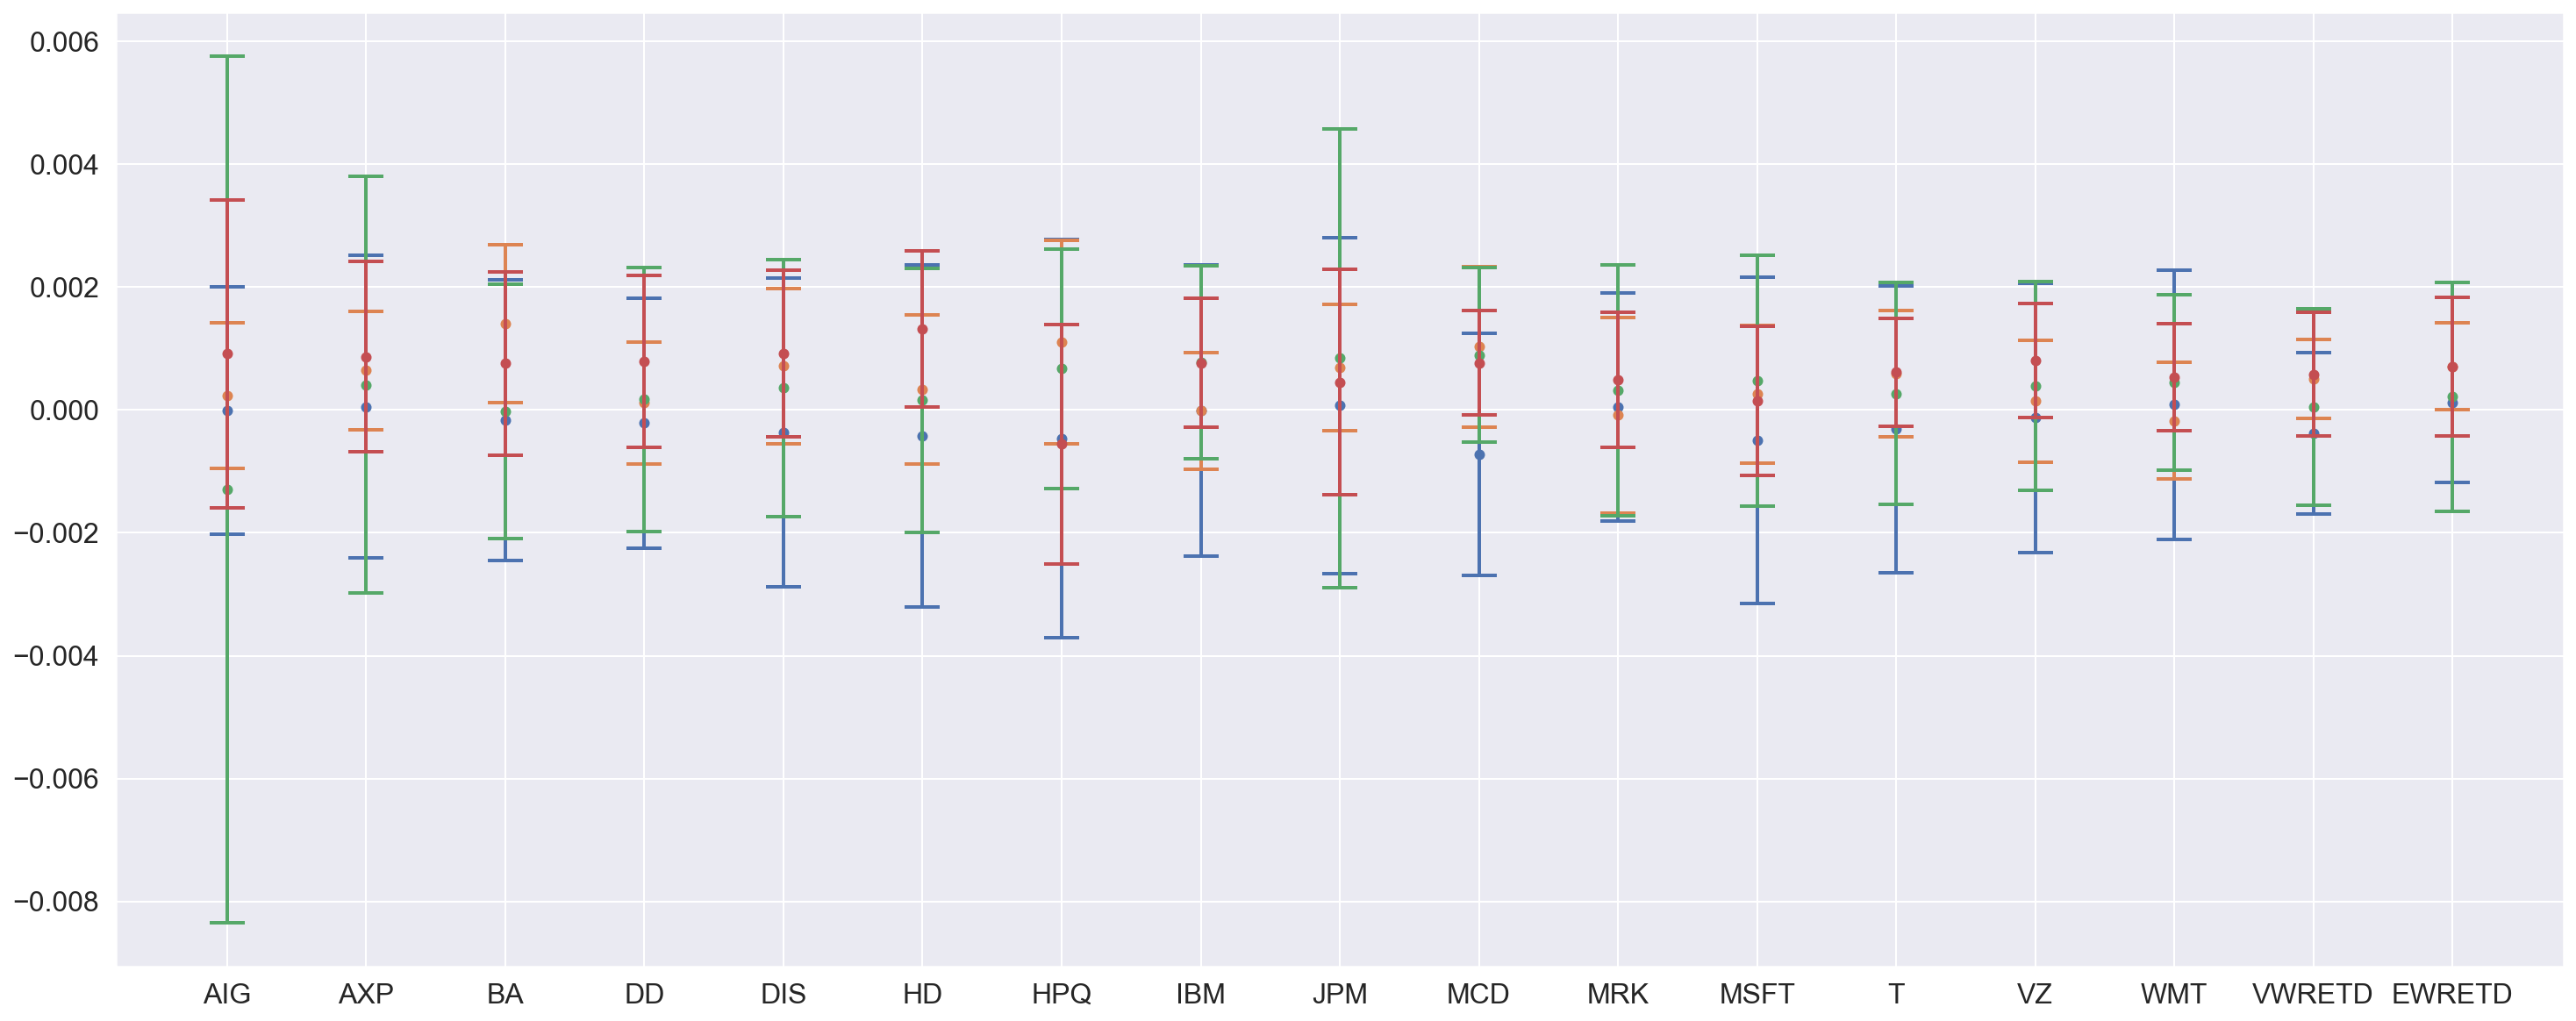

In [485]:
fig,ax = plt.subplots(figsize=(25,10))
for i in range(17):
    colors = sns.color_palette(n_colors= 4)
    for j in range(4):
        entry = conf_interval_subgroup.iloc[j*17+i]
        plt.plot( (i,i),(entry.lower_bound,entry.upper_bound),marker='_',color=cm.colors.to_rgba(colors[j]),linewidth=2.0,markersize=20.0,markeredgewidth=2.0)
        plt.plot(i,entry['mean'],marker='.',c=cm.colors.to_rgba(colors[j]),markersize=10.0)
plt.xticks(ticks=range(17),labels=conf_interval.index)
plt.show()     

Similarly to Part 1 we notice a lot more variation amongs stocks vs. indices and in particular AIG which has the wided confidence intervals and intre-period variation. Indeces are again a lot more stable and range bound

#### Part 4

Calculate the kurtosis, skew and studentized range. Lets create a function to create the output we need

In [547]:
def calc_distributional_properties(x):
    kurtosis = x.kurtosis()
    skew = x.skew()
    sr = (x.max() - x.min())/x.std()
    return pd.Series({'skew':skew,'kurtosis':kurtosis,'studentized range':sr})

In [548]:
stats_df = daily_df.apply(calc_distributional_properties)
stats_df.T

,skew,kurtosis,studentized range
AIG,1.443548,57.768993,28.950643
AXP,0.391390,8.661732,15.015326
BA,-0.037447,4.797938,16.202366
DD,0.015732,4.757748,11.953218
DIS,0.163916,7.508041,16.373105
HD,-0.371223,12.610210,19.482097
HPQ,0.028067,6.786254,14.646620
IBM,0.258555,7.705462,16.140250
JPM,0.819962,12.103479,16.154286
MCD,-0.023150,5.304005,13.784602


In [549]:
subgrp_stats_df = daily_df.stack().groupby(level=[1,2]).apply(calc_distributional_properties).unstack(level=2)

Let's do all the stats at the same time this time to save some typing

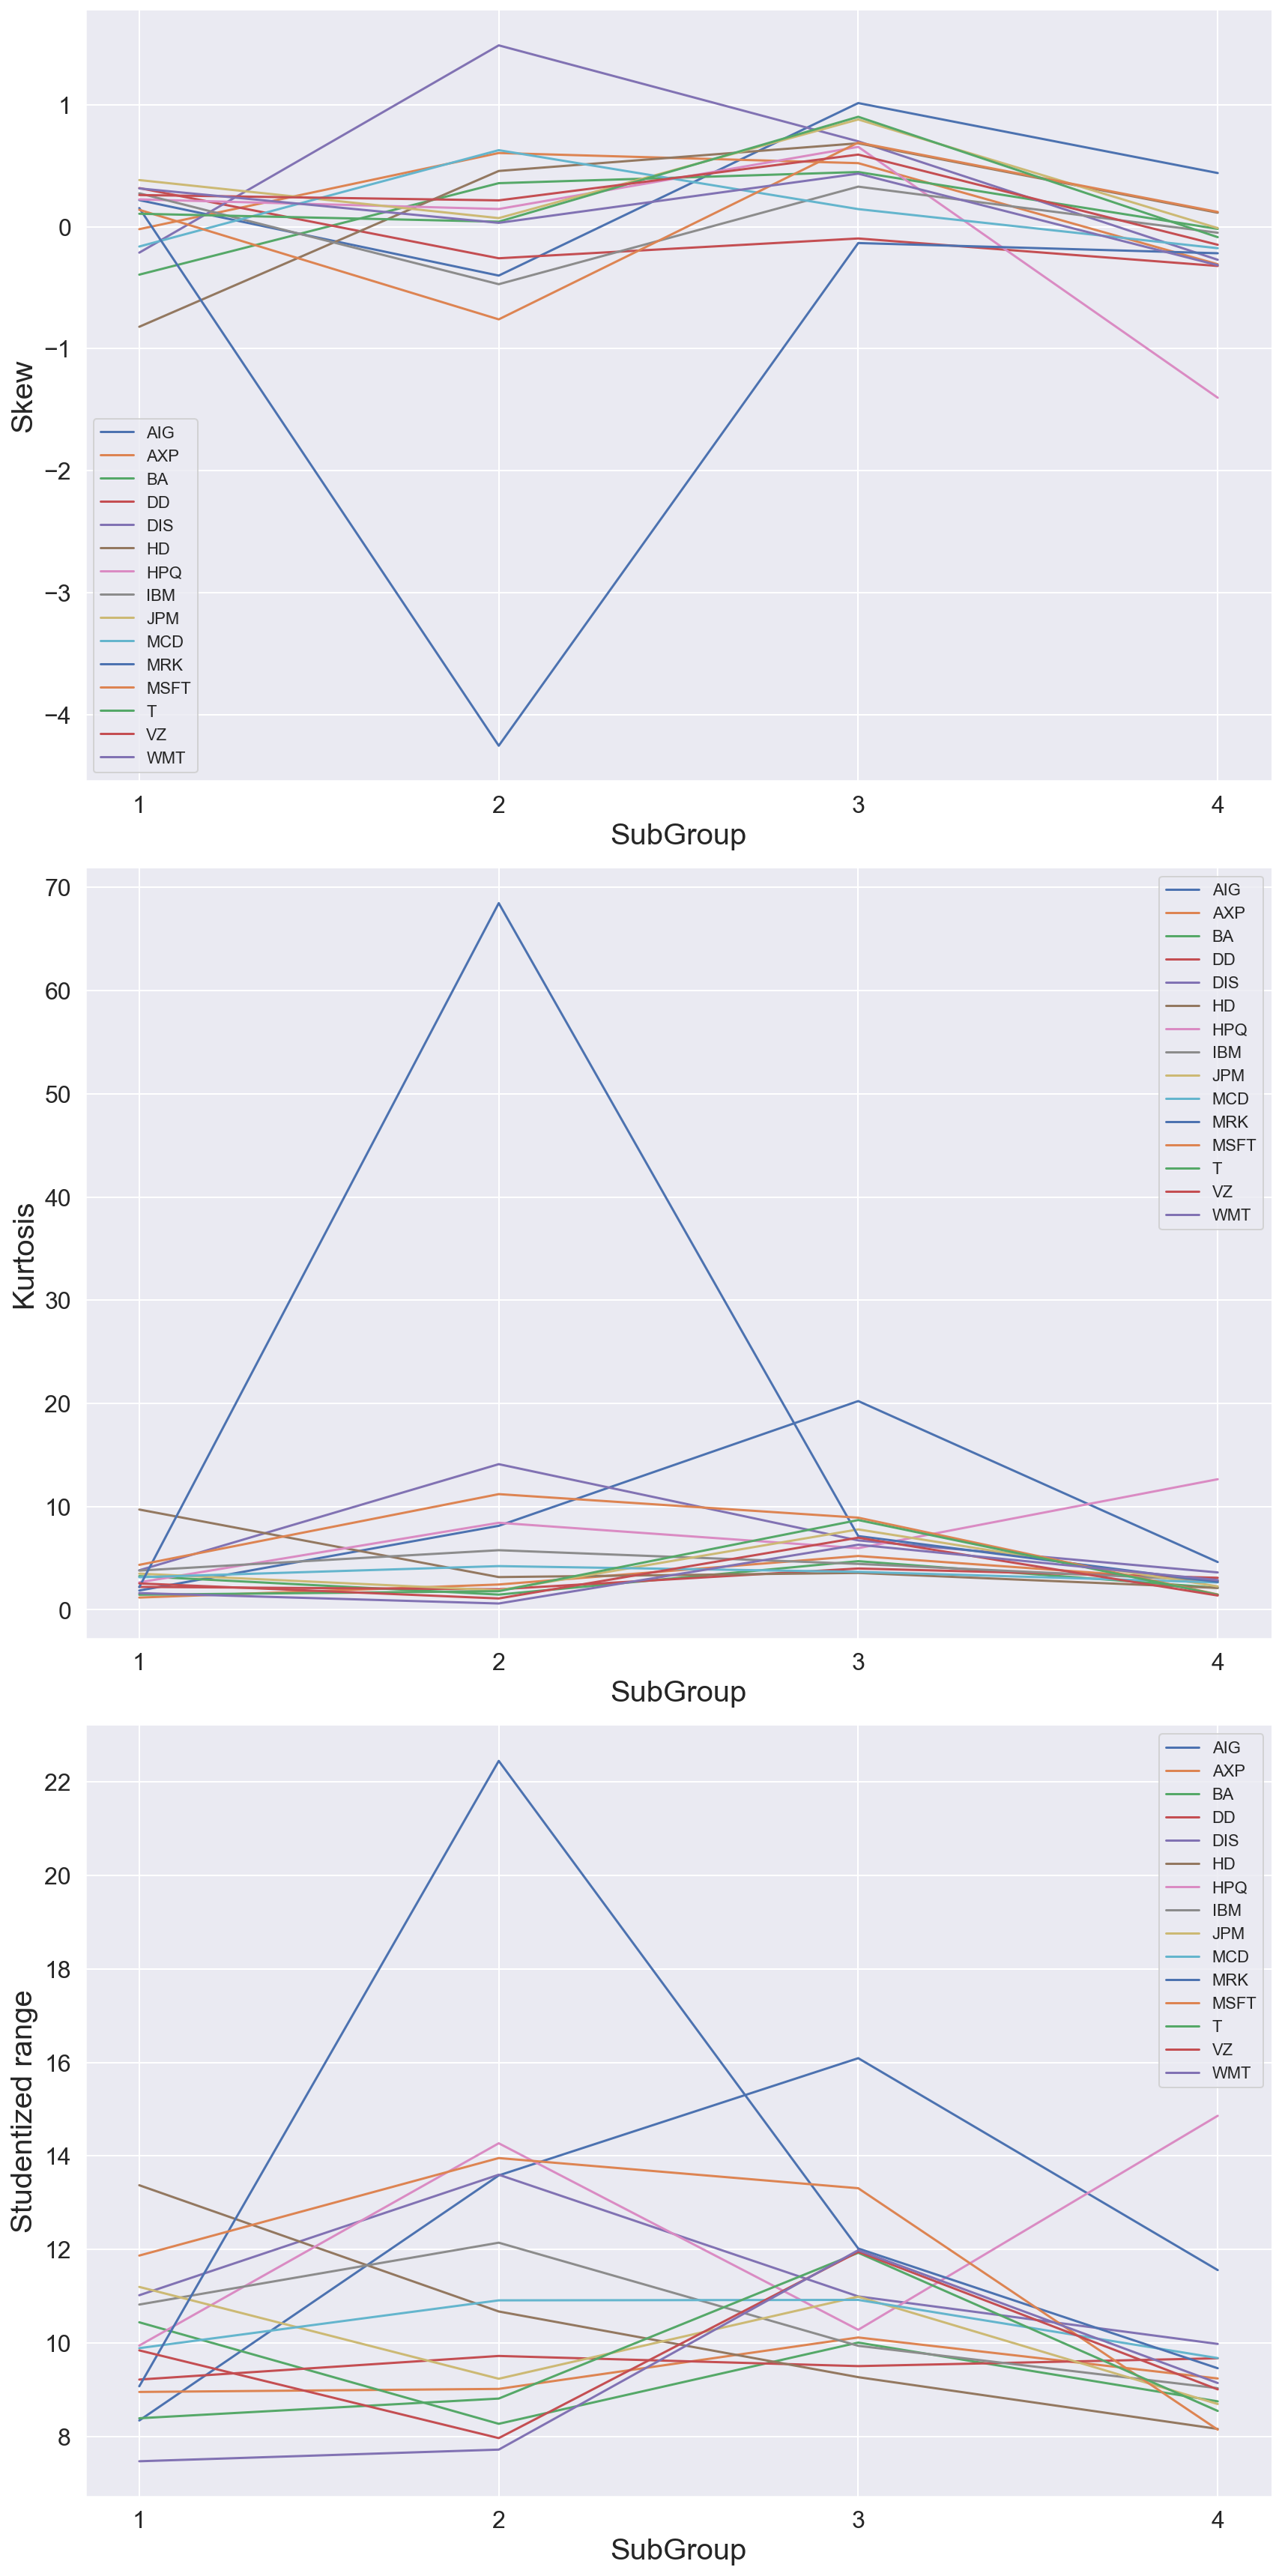

In [550]:
fig,ax = plt.subplots(3,1,figsize=(12,8*3))
for i, stat in enumerate(['skew','kurtosis','studentized range']):
    subgrp_stats_df.loc[pd.IndexSlice[:,stock_cols],stat].unstack(level=1).plot(ax = ax[i])
    _ = ax[i].set_xlabel('SubGroup')
    _ = ax[i].set_ylabel(stat.capitalize())
    _ = ax[i].legend()
    _ = ax[i].axes.set_xticklabels(labels = [str(i) for i in range(1,5) ])
    _ = ax[i].set_xticks(range(1,5))
sns.despine()
plt.tight_layout()
plt.show()

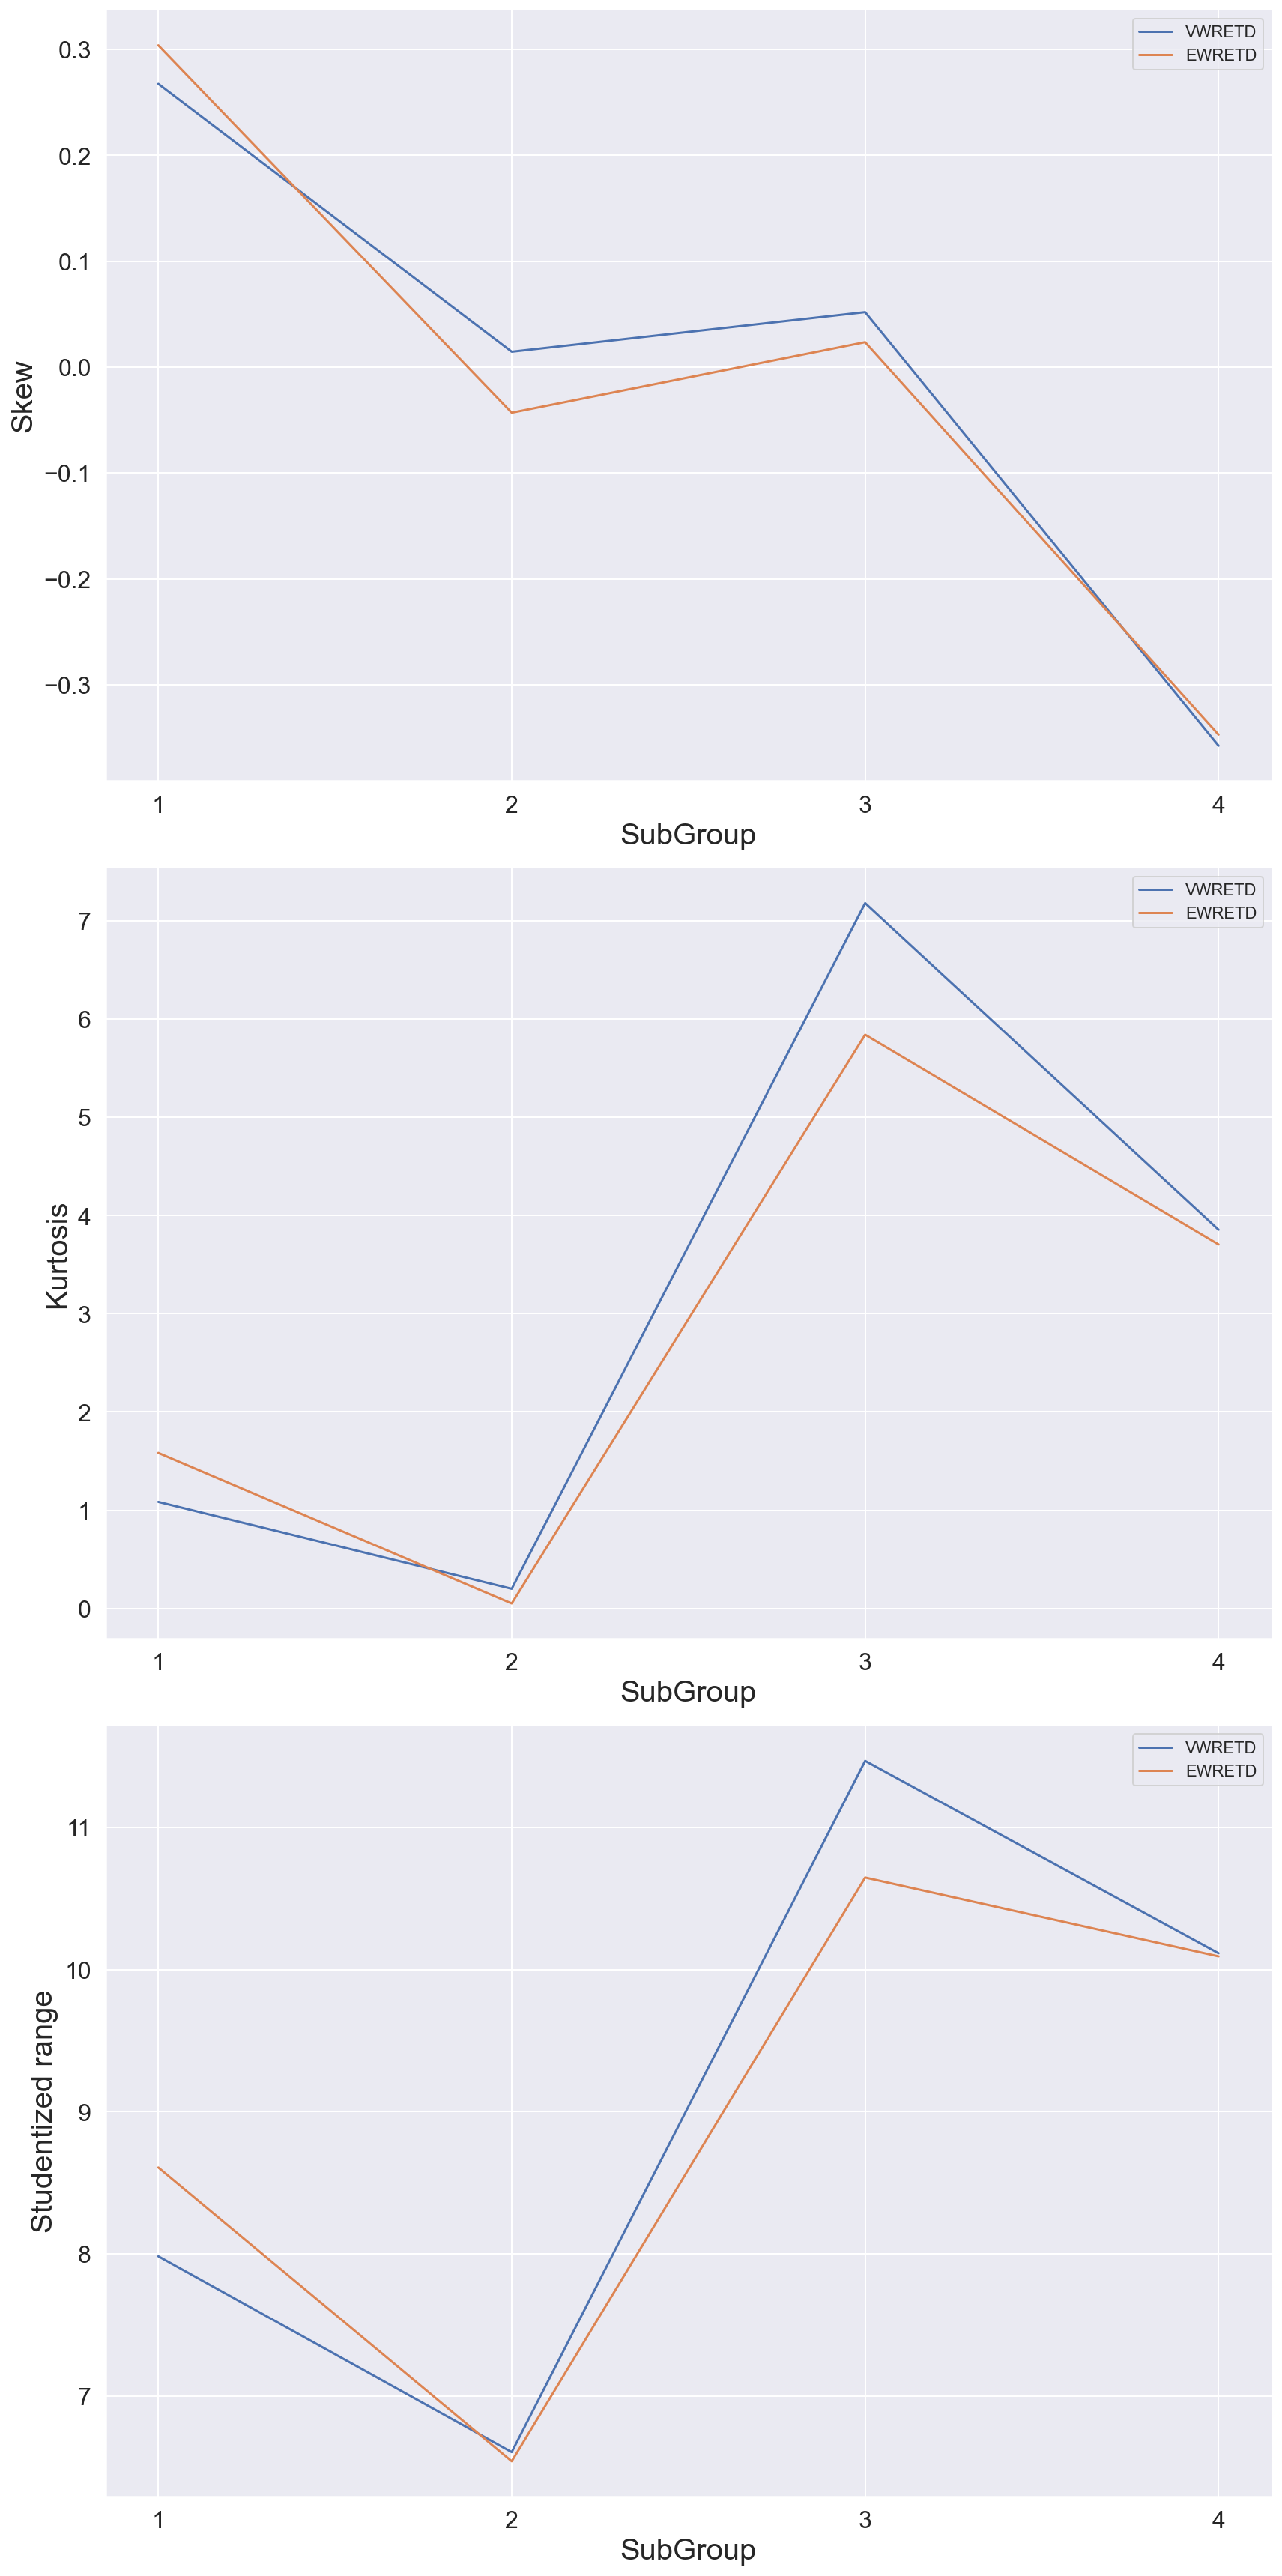

In [551]:
fig,ax = plt.subplots(3,1,figsize=(12,8*3))
for i, stat in enumerate(['skew','kurtosis','studentized range']):
    subgrp_stats_df.loc[pd.IndexSlice[:,idx_cols],stat].unstack(level=1).plot(ax = ax[i])
    _ = ax[i].set_xlabel('SubGroup')
    _ = ax[i].set_ylabel(stat.capitalize())
    _ = ax[i].legend()
    _ = ax[i].axes.set_xticklabels(labels = [str(i) for i in range(1,5) ])
    _ = ax[i].set_xticks(range(1,5))
sns.despine()
plt.tight_layout()

### TODO Add Commentary

### Exercise 2

For the data in Exercise 1, carry out the following:
1. Perform a PCA on the 15-stock returns. Using the eigenvalues of the $\hat{\Sigma}$ matrix, identify the number of factors.
2. Compute the covariance between the returns and the factors and comment.

As an exercise we'll do the PCA process by hand and then we can use sikit-learn to verify that we have done it right.

1. We start by calculating the mean for each column and we center each column around 0

In [573]:
daily_s_df = daily_df.loc[pd.IndexSlice[:,stock_cols]].reset_index(level=1,drop=True)

In [574]:
C  = daily_s_df - daily_s_df.mean()

2. Next we calculate the covariance matrix of the returns

In [577]:
V = C.cov()

3. Finally we do the egigen decomposition

In [583]:
e_values,e_vectors = np.linalg.eig(V)

The eigenvalue represent how much variance is explained by each of the factors. In order to do dimentionality reduction we want to choose only the number of factors that explain most of the variance and throwing away the rest.

We do that by sorting and normailzing the eignvalues. We plot the % of explained variance and we find the 'kink'  in the curve indicating that the additional factor explain less and less of the variance.

In [613]:
idx = np.argsort(e_values)[::-1] #Let's do argsort so we can then use it to chose the eigenvectors. argsort sorts ascending so we need to flip it
explained_variance = e_values[idx]/e_values.sum()

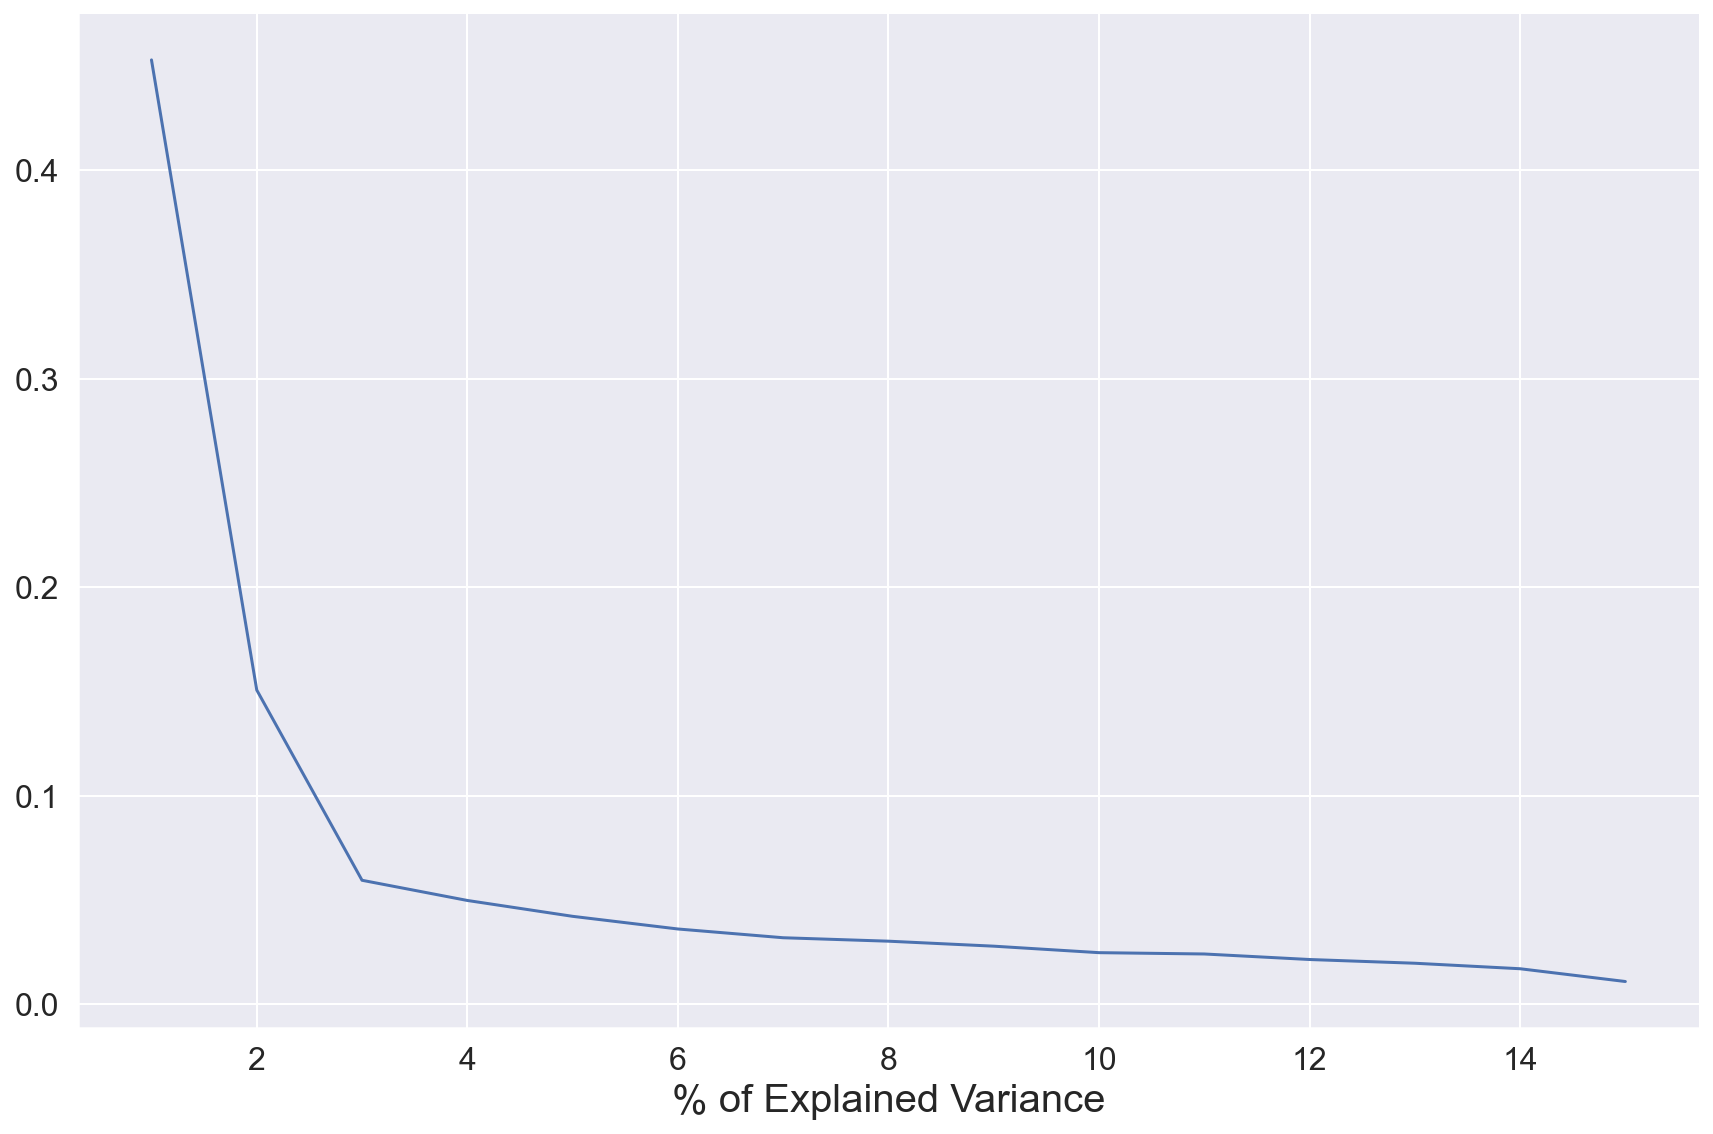

In [634]:
fig,ax = plt.subplots(figsize=(12,8))
_ = plt.plot(range(1,16),explained_variance)
_ = plt.xlabel('Factors')
_ = plt.xlabel('% of Explained Variance')
sns.despine()
plt.tight_layout()
plt.show()

Based on our approach we shold chose the first 3 factor. Let's look at how much of the variance is explained

In [629]:
print(f'Explained Varianve: {np.round(explained_variance[:3].sum()*100,2)}%')


Explained Varianve: 66.32%


The eigen vectors represent the **Factor Loadings** for each of the principal factors. We obtain the principal factor time series of returns is calcualted by doing a linear combination of the returns multiplied by the chose eigen vectors

In [631]:
pca_factors = daily_s_df.dot(e_vectors[idx[0:3]].T)
pca_factors.shape

(3323, 3)

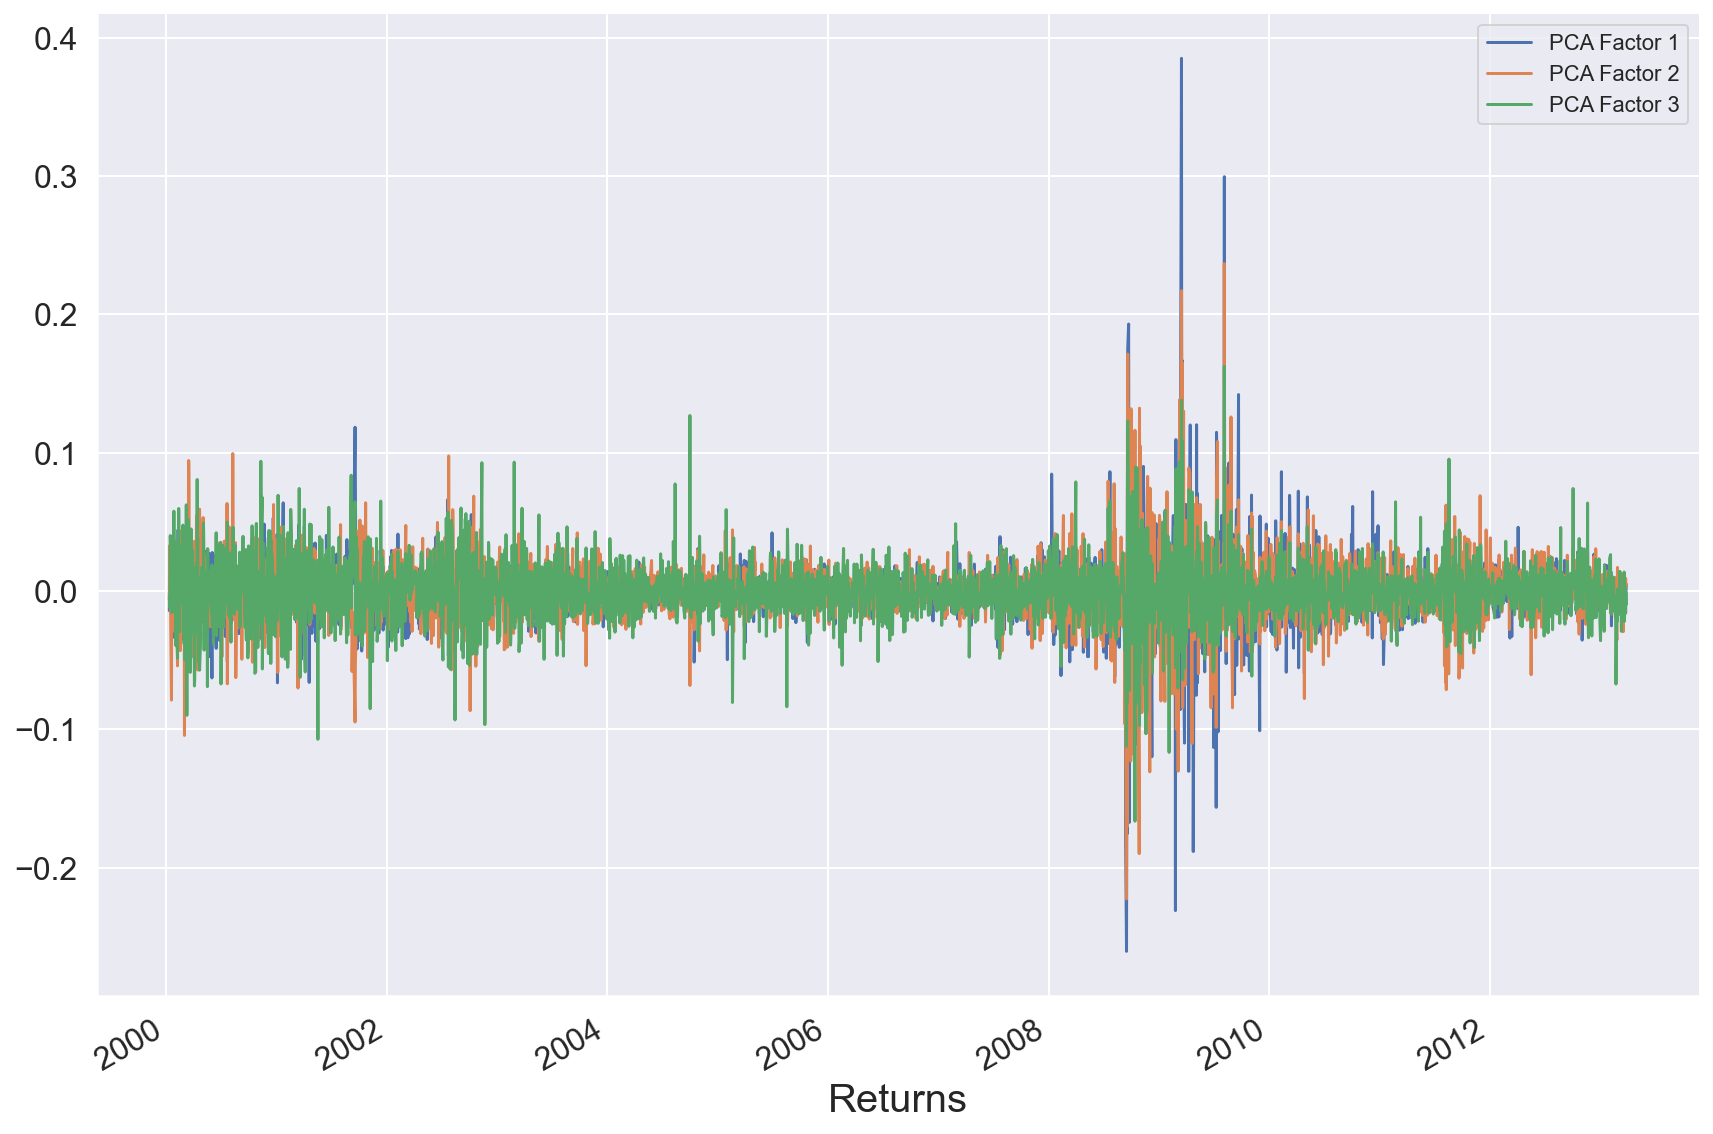

In [636]:
fig,ax = plt.subplots(figsize=(12,8))
_ = pca_factors.plot(ax=ax)
_ = plt.xlabel('Returns')
_ = plt.legend(['PCA Factor 1','PCA Factor 2','PCA Factor 3'])
sns.despine()
plt.tight_layout()
plt.show()

In [666]:
np.sqrt(np.cov(C.values[:,0],pca_factors[0]))

array([[0.0437955 , 0.02451863],
       [0.02451863, 0.0243188 ]])

In [667]:
daily_s_df.values[:,0].shape,pca_factors.shape

((3323,), (3323, 3))

In [668]:
pca = PCA(n_components=3)
pca.fit(daily_s_df)

PCA(n_components=3)

In [671]:
pca.explained_variance_ratio_.sum()

0.6632318120278119

In [675]:
pca.

array([3.46414705, 1.99860282, 1.25578966])

In [659]:
np.cov?

Signature:
np.cov(
    m,
    y=None,
    rowvar=True,
    bias=False,
    ddof=None,
    fweights=None,
    aweights=None,
)
Docstring:
Estimate a covariance matrix, given data and weights.

Covariance indicates the level to which two variables vary together.
If we examine N-dimensional samples, :math:`X = [x_1, x_2, ... x_N]^T`,
then the covariance matrix element :math:`C_{ij}` is the covariance of
:math:`x_i` and :math:`x_j`. The element :math:`C_{ii}` is the variance
of :math:`x_i`.

See the notes for an outline of the algorithm.

Parameters
----------
m : array_like
    A 1-D or 2-D array containing multiple variables and observations.
    Each row of `m` represents a variable, and each column a single
    observation of all those variables. Also see `rowvar` below.
y : array_like, optional
    An additional set of variables and observations. `y` has the same form
    as that of `m`.
rowvar : bool, optional
    If `rowvar` is True (default), then each row represents a
    variable